# Section A

### Solutions to Question 1

* **Question 1.1:** Can there exist an estimator with the smaller MSE than minimal least squares?
<br>
* **Solution 1.1:** The answer is No. Most machine learning models try to minimize the loss function, which in this case the mean squared error, and find the global minima. Global minima is a point on the loss function where the mean squared error is the lowest. Hence we cannot have estimators with MSE smaller than minimal least sqaures.
<br>
<br>
* **Question 1.2:** For a prediction, does the MSE measure an irreducible error or model error?
<br>
* **Solution 1.2:** The answer is No. MSE is a combination of both irreducible error and the reducible error.The irreducible error is caused due to the randomness in the data and the reducible error gets introduced by the model performance of predicting the target values. 
<br>

### Solutions to Question 2

* **Question 2.1:** high entropy means the partitions are pure.
<br>
<br>
* **Solution 2.1:** The answer is No. Entropy signifies the impurity in split in case of a decision tree.
<br>
<br>
* $Entropy = -$$\sum_{1}^{n}$$P_i*log(P_i)$
<br>
<br>
* where $P_i$ is the probability of class. 
<br>
<br>
* Entropy ranges from 0 to 1 and the plot of an entropy is an inverted parabola with the entropy value peaking at 1 for P=0.5. Hence entropy is the highest where the probablity of an observation belonging to particular class is 0.5, which is random in case of binary classification task. 
<br>
<br>
* **Question 2.2:** high entropy means the partitions are not pure.
<br>
<br>
* **Solution 2.2:** The answer is Yes. Since, Entropy ranges from 0 to 1 and the plot of an entropy is an inverted parabola with the entropy value peaking at 1 for P=0.5. Hence, higher entopy signifies more impurity in the partitions.

In [3]:
import copy
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from sklearn.svm import SVC
import scipy.stats as stats
from matplotlib import pyplot
from tabulate import tabulate
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from matplotlib.gridspec import GridSpec
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split, 
                                    RandomizedSearchCV, 
                                    TimeSeriesSplit, 
                                    cross_val_score
                                    )

from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score

Downloading and storing the stock pirces for the company TATA Steel from National Stock Exchange in India. Storing the stock prices into a .csv file

In [ ]:
tatam_df= yf.download("TATASTEEL.NS", start="2000-01-01", end="2023-06-05",interval="1d")

In [ ]:
tatam_df.to_csv('tata_steel.csv',index=False)

In [4]:
tatam_df= pd.read_csv('tata_steel.csv')
tatam_df.columns= tatam_df.columns.str.lower()

Description of the Dataframe as received

In [58]:
print("Shape of the Dataframe: {}".format(tatam_df.shape))
print("Number of Rows/number of days the prices have been picke up in the Dataframe: {}".format(tatam_df.shape[0]))
print("Number of Columns in the Dataframe: {}".format(tatam_df.shape[1]))

Shape of the Dataframe: (5851, 7)
Number of Rows/number of days the prices have been picke up in the Dataframe: 5851
Number of Columns in the Dataframe: 7


In [4]:
print("Columns present in the raw dataframe as received from the ticker: \n{}".format(list(tatam_df.columns)))

Columns present in the raw dataframe as received from the ticker: 
['date', 'open', 'high', 'low', 'close', 'adj close', 'volume']


In [ ]:
null_df= pd.DataFrame(tatam_df.isnull().sum())
null_df.reset_index(inplace=True)
null_df.columns=['Column_name','number of NA values']
print("Total number of NA values in each of the columns in the dataframe")
null_df

### Feature Creation

* We use Open, Close, High Low, Adjusted Close prices, One-day Volume change, 21-day Volume change, lagged returns (up to 5 lags), the lagged returns over 5 day and 21 day.
<br>
<br>
* 5-day Simple Moving Average, 5-day cunulative Moving Average, 5-day Exponential Moving Average and 21-day rolling volatility.
<br>
<br>
* Intra-day price range, Sign of return and Momentum

In [5]:
def feature_creation(df,period):
    df.sort_values(by=['date'], ascending=True)
    df['oc']= df['close']/df['open']-1
    df['hl']= df['high']/df['low']-1
    df['log_returns']= np.log(df['adj close']/df['adj close'].shift(1))
    df['sign']= np.sign(df['log_returns'])

    nums=period
    for i in range(1,nums+1):
        col_name= 'ret'+'_'+str(i)+'d'
        df[col_name]= df['log_returns'].shift(i)

    df['sma_'+str(period)+'d']= df['adj close'].rolling(period).mean()
    df['cma'+str(period)+'d']= df['adj close'].expanding().mean()
    df['ema'+str(period)+'d']= df['adj close'].ewm(span=period, adjust=False).mean()

    df['21d_ret']= np.log(df['adj close']/df['adj close'].shift(21))
    
    df['std_'+str(period)+'d']= df['ret_1d'].rolling(5).std() 
    df['21d_std']= df['ret_1d'].rolling(21).std()
    
    df['vol_1d_chg']= df['volume'].diff(1)
    df['vol_21d_chg']= df['volume'].diff(21)
    
    return df

In [6]:
tatam_df= feature_creation(tatam_df,5)
print(tatam_df.shape)
tatam_df.head()

(5851, 24)


,date,open,high,low,close,adj close,volume,oc,hl,log_returns,...,ret_4d,ret_5d,sma_5d,cma5d,ema5d,21d_ret,std_5d,21d_std,vol_1d_chg,vol_21d_chg
0,2000-01-03,8.309460,8.601414,8.202785,8.559305,2.041356,35678775,0.030068,0.048597,NaN,...,NaN,NaN,NaN,2.041356,2.041356,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,8.427365,8.590185,8.031542,8.466666,2.019262,27698564,0.004663,0.069556,-0.010882,...,NaN,NaN,NaN,2.030309,2.033991,NaN,NaN,NaN,-7980211.0,NaN
2,2000-01-05,8.118567,9.146021,8.118567,8.789500,2.096257,68399389,0.082642,0.126556,0.037421,...,NaN,NaN,NaN,2.052292,2.054746,NaN,NaN,NaN,40700825.0,NaN
3,2000-01-06,8.924248,9.494120,8.924248,9.446396,2.252923,45604218,0.058509,0.063857,0.072075,...,NaN,NaN,NaN,2.102449,2.120805,NaN,NaN,NaN,-22795171.0,NaN
4,2000-01-07,9.735543,10.049955,9.336914,9.654133,2.302468,64862245,-0.008362,0.076368,0.021753,...,NaN,NaN,2.142453,2.142453,2.181359,NaN,NaN,NaN,19258027.0,NaN


### Dropping the NAN values from the dataset

In [7]:
tatam_df.dropna(inplace= True)
print(tatam_df.shape)

(5829, 24)


### Creating the Target Variable

In [8]:
tatam_df['target']= np.where(tatam_df['adj close'].shift(-1)>0.995 * tatam_df['adj close'],1,0) 

In [62]:
tatam_df['target'].nunique()

2

In [7]:
tatam_df['target'].value_counts()

1    3601
0    2228
Name: target, dtype: int64

In [8]:
tatam_df_dict= np.round((tatam_df['target'].value_counts()/tatam_df['target'].shape[0])*100,2)

In [9]:
tatam_df.drop(['open','close','high','low','adj close','volume'], axis=1, inplace=True)

### Train Test Split of the Dataframe

In [10]:
y= tatam_df['target']
tatam_df.drop(['target'],axis=1,inplace=True)
x= tatam_df

In [ ]:
(y.value_counts())/y.shape[0]

In [55]:
train_x,test_x,train_y,test_y= train_test_split(x,y, test_size=0.2, random_state=14, shuffle=False)

print("Shape of the Train_x: {}".format(train_x.shape))
print("Shape of the Test_x: {}".format(test_x.shape))
print("Shape of the Train_y: {}".format(train_y.shape))
print("Shape of the Test_y: {}".format(test_y.shape))

train_x.reset_index(drop= True,inplace= True)
test_x.reset_index(drop= True,inplace= True)
train_y.reset_index(drop=True, inplace= True)
test_y.reset_index(drop=True, inplace=True)

Shape of the Train_x: (4663, 18)
Shape of the Test_x: (1166, 18)
Shape of the Train_y: (4663,)
Shape of the Test_y: (1166,)


In [56]:
tatam_df['target']=y
train_x['target']= train_y
test_x['target']= test_y

print("Unique elements in Overall dataset target column: ",tatam_df['target'].unique())
print("Unique elements in Train dataset target column: ",train_x['target'].unique())
print("Unique elements in Test dataset target column: ",test_x['target'].unique())

Unique elements in Overall dataset target column:  [0 1]
Unique elements in Train dataset target column:  [0 1]
Unique elements in Test dataset target column:  [1 0]


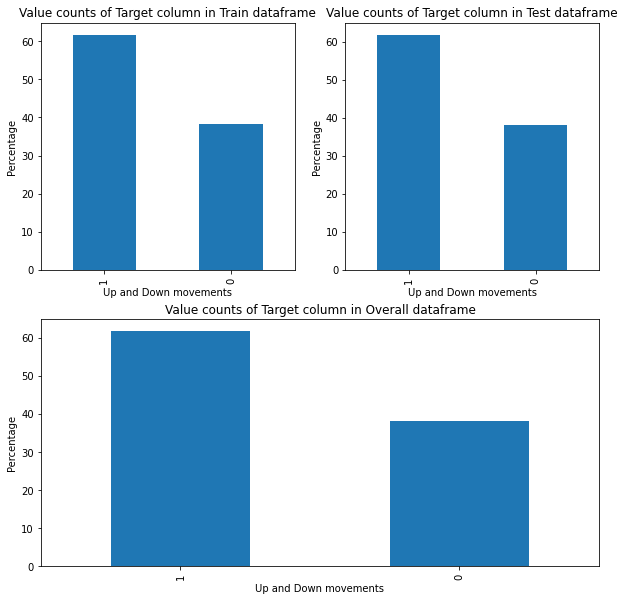

In [11]:
fig= plt.figure(figsize=(10,10))
gs= GridSpec(2,2,figure= fig)

ax1= fig.add_subplot(gs[0,0])
ax2= fig.add_subplot(gs[0,1])
ax3= fig.add_subplot(gs[1,:])

np.round((train_x['target'].value_counts()/train_x.shape[0])*100,2).plot(ax=ax1,kind='bar')
np.round((test_x['target'].value_counts()/test_x.shape[0])*100,2).plot(ax=ax2,kind='bar')
np.round((tatam_df['target'].value_counts()/tatam_df.shape[0])*100,2).plot(ax=ax3,kind='bar')


ax1.set_xlabel('Up and Down movements')
ax2.set_xlabel('Up and Down movements')
ax3.set_xlabel('Up and Down movements')

ax1.set_ylabel('Percentage')
ax2.set_ylabel('Percentage')
ax3.set_ylabel('Percentage')

ax1.set_title('Value counts of Target column in Train dataframe')
ax2.set_title('Value counts of Target column in Test dataframe')
ax3.set_title('Value counts of Target column in Overall dataframe')

plt.show()

**Plot Description:**
<br>
<br>
* The above plot looks at the distribution of the data in the Target class across 0 and 1 classes for the overall dataset, Train and test datasets.
<br>
<br>
* We can see from the plot that the distribution is the same in both the Train and Test datasets and also represents the distribution of the overall dataset.
<br>
<br>
* In all the three datasets, the target class is split between 0 and 1 class in close 40:60 ratio respectively

### Month-on-Month trends in the 1Day,2Day,3Day,4Day,5Day Returns and various types of Moving averages

In [12]:
train_x['date']= pd.to_datetime(train_x['date'])
train_x['month']= train_x['date'].dt.strftime('%b')
train_x['year']= train_x['date'].dt.year

In [13]:
train_x['yr_mon']= train_x['month'].astype('str')+'-'+train_x['year'].astype('str')

In [111]:
mom_1dret_mean= pd.DataFrame(train_x.groupby(by=['year','month'])['ret_1d','ret_2d','ret_3d','ret_4d','ret_5d'].mean())
mom_1dret_mean.reset_index(level=[0,1],inplace=True)

C:\Users\satyaav\AppData\Local\Temp/ipykernel_12768/3474607749.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mom_1dret_mean= pd.DataFrame(train_x.groupby(by=['year','month'])['ret_1d','ret_2d','ret_3d','ret_4d','ret_5d'].mean())


In [112]:
mom_1dret_mean['yr_mon']= mom_1dret_mean['month'].astype('str')+'-'+mom_1dret_mean['year'].astype('str')
mom_1dret_mean.head()

,year,month,ret_1d,ret_2d,ret_3d,ret_4d,ret_5d,yr_mon
0,2000,Apr,0.002994,0.006558,0.003043,0.005404,0.006342,Apr-2000
1,2000,Aug,-0.003067,-0.003076,-0.002202,-0.003724,-0.002338,Aug-2000
2,2000,Dec,0.001905,0.000333,0.000297,0.002443,0.004243,Dec-2000
3,2000,Feb,-0.003185,-0.005868,-0.007010,-0.007119,-0.006157,Feb-2000
4,2000,Jul,-0.001252,-0.001628,-0.001805,-0.000709,-0.002721,Jul-2000


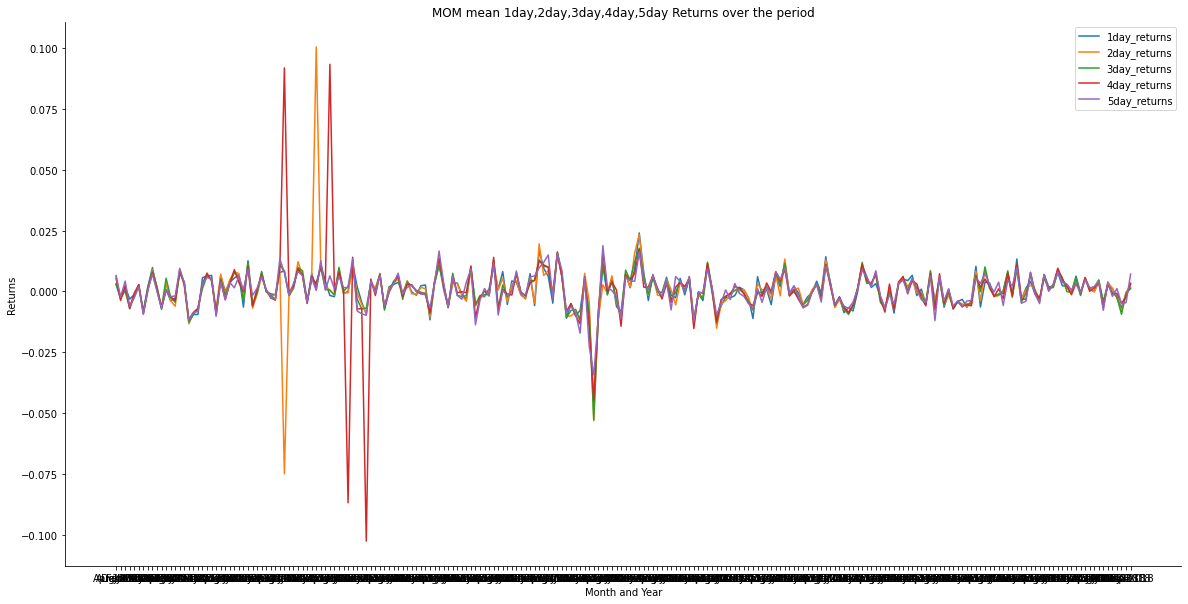

In [113]:
plt.figure(figsize=(20,10))
sns.lineplot(data= mom_1dret_mean, x='yr_mon',y='ret_1d', label='1day_returns')
sns.lineplot(data= mom_1dret_mean, x='yr_mon',y='ret_2d', label='2day_returns')
sns.lineplot(data= mom_1dret_mean, x='yr_mon',y='ret_3d', label='3day_returns')
sns.lineplot(data= mom_1dret_mean, x='yr_mon',y='ret_4d', label='4day_returns')
sns.lineplot(data= mom_1dret_mean, x='yr_mon',y='ret_5d', label='5day_returns')

plt.legend(loc='upper right')
sns.despine()
plt.xlabel('Month and Year')
plt.ylabel('Returns')
plt.title('MOM mean 1day,2day,3day,4day,5day Returns over the period')
plt.show()

**Plot Description and Observations:**
<br>
<br>
* The above plot shows the trend of the Mean Month-on-month 1-day,2-day,3-day,4-day and 5-day returns starting from January 2000 to June 2023.
<br>
<br>
* We can see from the plot that the trend for all different varieties of returns remain similar with major spikes happening in year 2008

C:\Users\satyaav\AppData\Local\Temp/ipykernel_12768/327645970.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mav_mean= pd.DataFrame(train_x.groupby(by=['year','month'])['sma_5d', 'cma5d', 'ema5d'].mean())


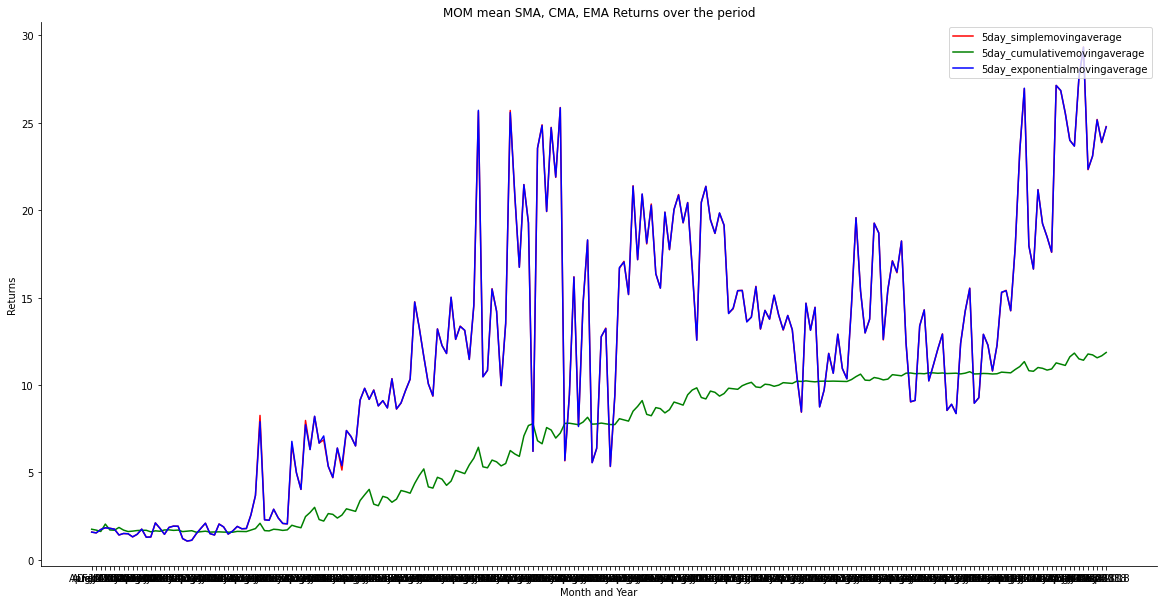

In [78]:
mav_mean= pd.DataFrame(train_x.groupby(by=['year','month'])['sma_5d', 'cma5d', 'ema5d'].mean())
mav_mean.reset_index(level=[0,1],inplace=True)
mav_mean['yr_mon']= mav_mean['month'].astype('str')+'-'+mav_mean['year'].astype('str')

plt.figure(figsize=(20,10))
sns.lineplot(data= mav_mean, x='yr_mon',y='sma_5d', label='5day_simplemovingaverage', color='red')
sns.lineplot(data= mav_mean, x='yr_mon',y='cma5d', label='5day_cumulativemovingaverage', color='green')
sns.lineplot(data= mav_mean, x='yr_mon',y='ema5d', label='5day_exponentialmovingaverage', color='blue')

plt.legend(loc='upper right')
sns.despine()
plt.xlabel('Month and Year')
plt.ylabel('Returns')
plt.title('MOM mean SMA, CMA, EMA Returns over the period')

plt.show()

**Plot Description and Observations:**
<br>
* The above plot shows the trend of the Mean Month-on-month Simple Moving Average, Cumulative moving Average and Exponential Moving Averages.
<br>
<br>
* As indicated in the Legened, the Simple Moving Avergare is signified by the Red line,Cumulative Moving Average by the green line and the Exponentoal Moving average by the blue line.Note:There is a major overlap between the simple moving average and the exponential moving average.
<br>
<br>
* As expected the simple and exponential moving averages are more jagged with heave spikes acorss the timeline whereas the cumulative moving average is much smoother curve.
<br>
<br>
* Sma and ema capture the trends in the shortterm as well along with capturing the overall trend of the movments of the stock.
<br>
<br>
* Whereas the cumulative moving average effectively cpatured the overall trend in the stock price movement but does not effectively capture the short term spikes.


In [14]:
train_x.drop(['date', 'month', 'year','yr_mon'],axis=1, inplace=True)
test_x.drop(['date'],axis=1, inplace=True)

In [13]:
tr_y= train_x['target']
te_y= test_x['target']
train_x.drop(['target'],axis=1,inplace=True)
test_x.drop(['target'],axis=1,inplace=True)

### Scaling of the Independent Features using StandardScaler

**Feature Scaling using Standard Scaler**
<br>
* We perform feature scaling in order to get all the features on to the same scale.
<br>
<br>
* Scaling is more effective for distance based algorithms such as linear/logistic regression, SVM etc.
<br>
<br>
* Standard scaler brings the range of all values between 0 and 1 by centering all the observations around the mean. This is achieved by taking the difference between each of the observations and the mean and subsequently diving the difference by the standard deviation.
<br>
<br>
$$\frac{(X_{obs}-\mu)}{\sigma}$$

In [15]:
ss= StandardScaler()
train_x_std= pd.DataFrame(ss.fit_transform(train_x))
test_x_std= pd.DataFrame(ss.transform(test_x))

train_x_std.columns= train_x.columns
test_x_std.columns= test_x.columns

### Exploratory Data Analysis

#### Univariate Analysis

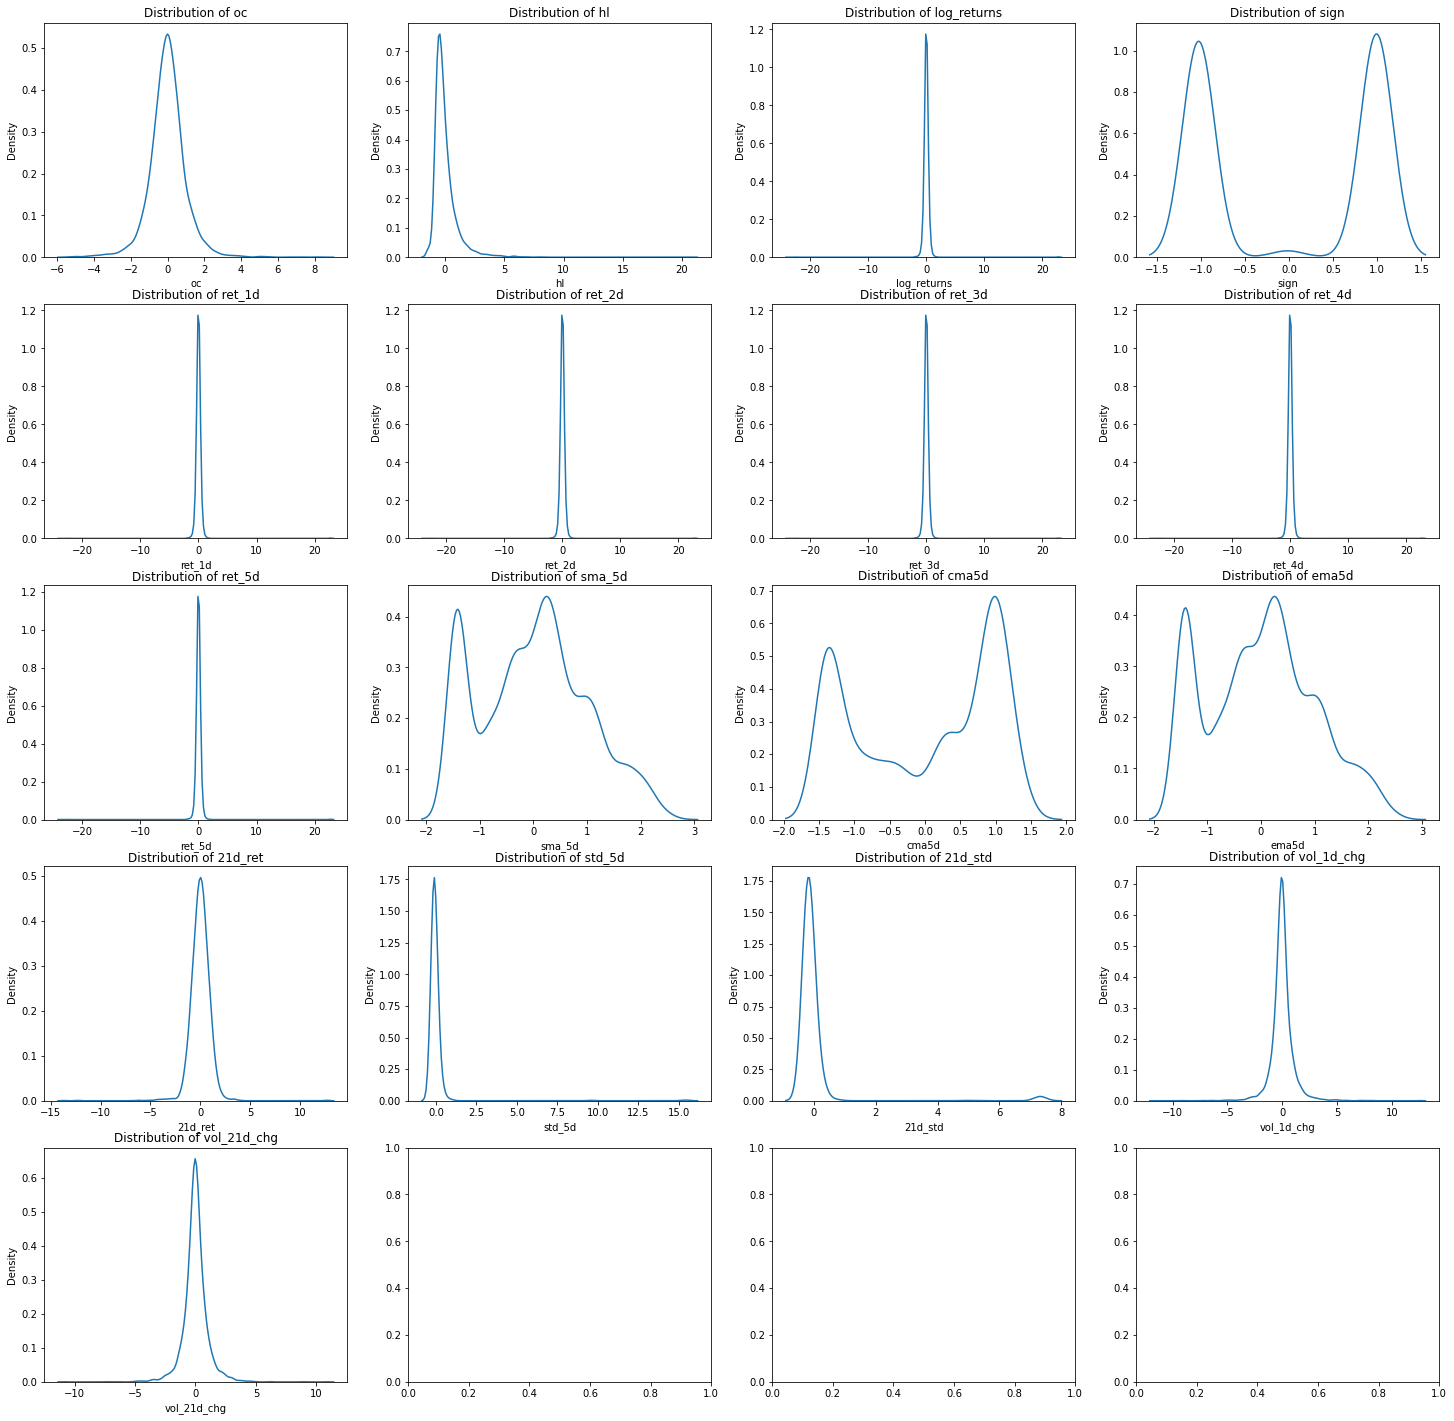

In [136]:
fig= plt.figure(figsize=(25,25))
gs= GridSpec(5,4,figure= fig)

a=1
axes_list=[]
for i in range(5):
    for j in range(4):
        axes= 'ax'+str(a)
        axes= fig.add_subplot(gs[i,j])
        axes_list.append(axes)
        a=a+1
        
for num,col in enumerate(train_x.columns):
    sns.kdeplot(ax= axes_list[num],data= train_x_std,x= col)
    axes_list[num].title.set_text('Distribution of' + ' '+ col)

In [16]:
train_x_std['target']= tr_y
test_x_std['target']= te_y

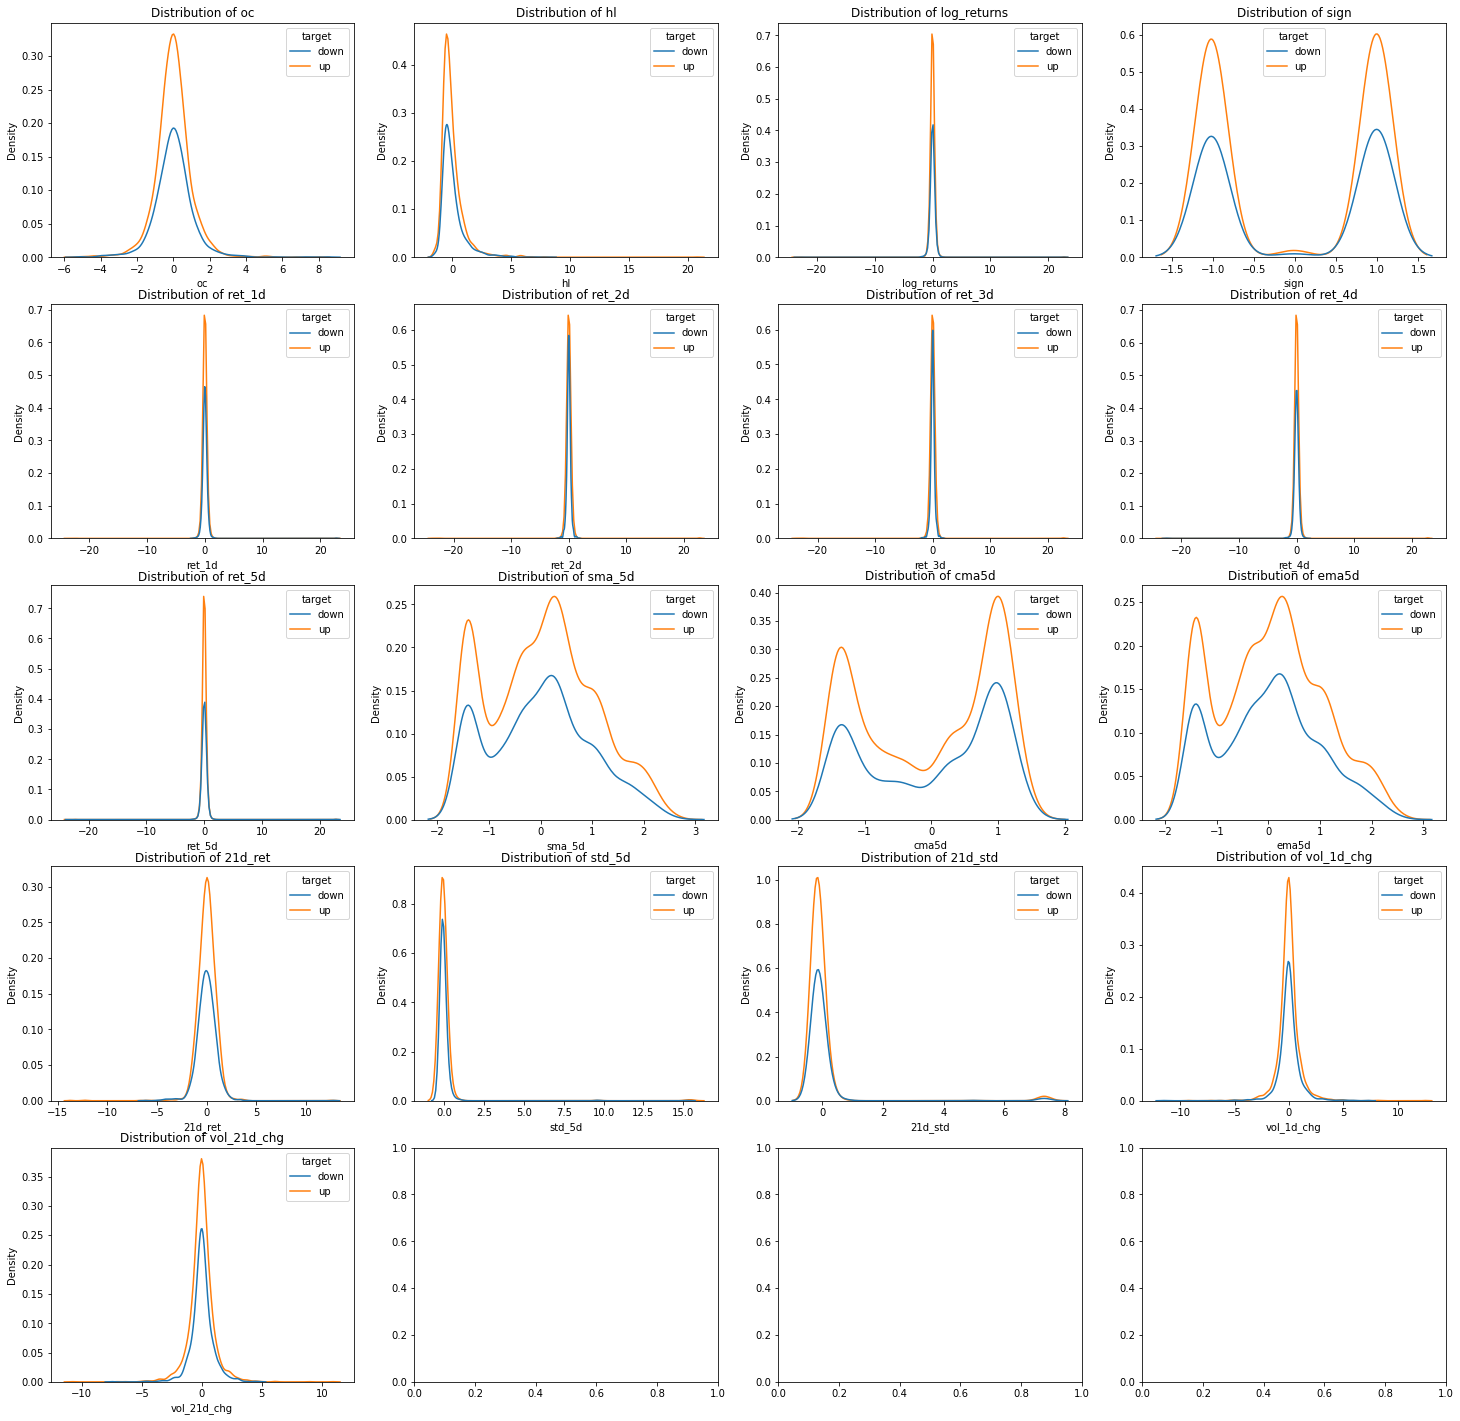

In [139]:
fig= plt.figure(figsize=(25,25))
gs= GridSpec(5,4,figure= fig)

a=1
axes_list=[]
for i in range(5):
    for j in range(4):
        axes= 'ax'+str(a)
        axes= fig.add_subplot(gs[i,j])
        axes_list.append(axes)
        a=a+1
        
for num,col in enumerate(train_x.columns):
    sns.kdeplot(ax= axes_list[num],data= train_x_std,x= col, hue='target')
    axes_list[num].title.set_text('Distribution of' + ' '+ col)

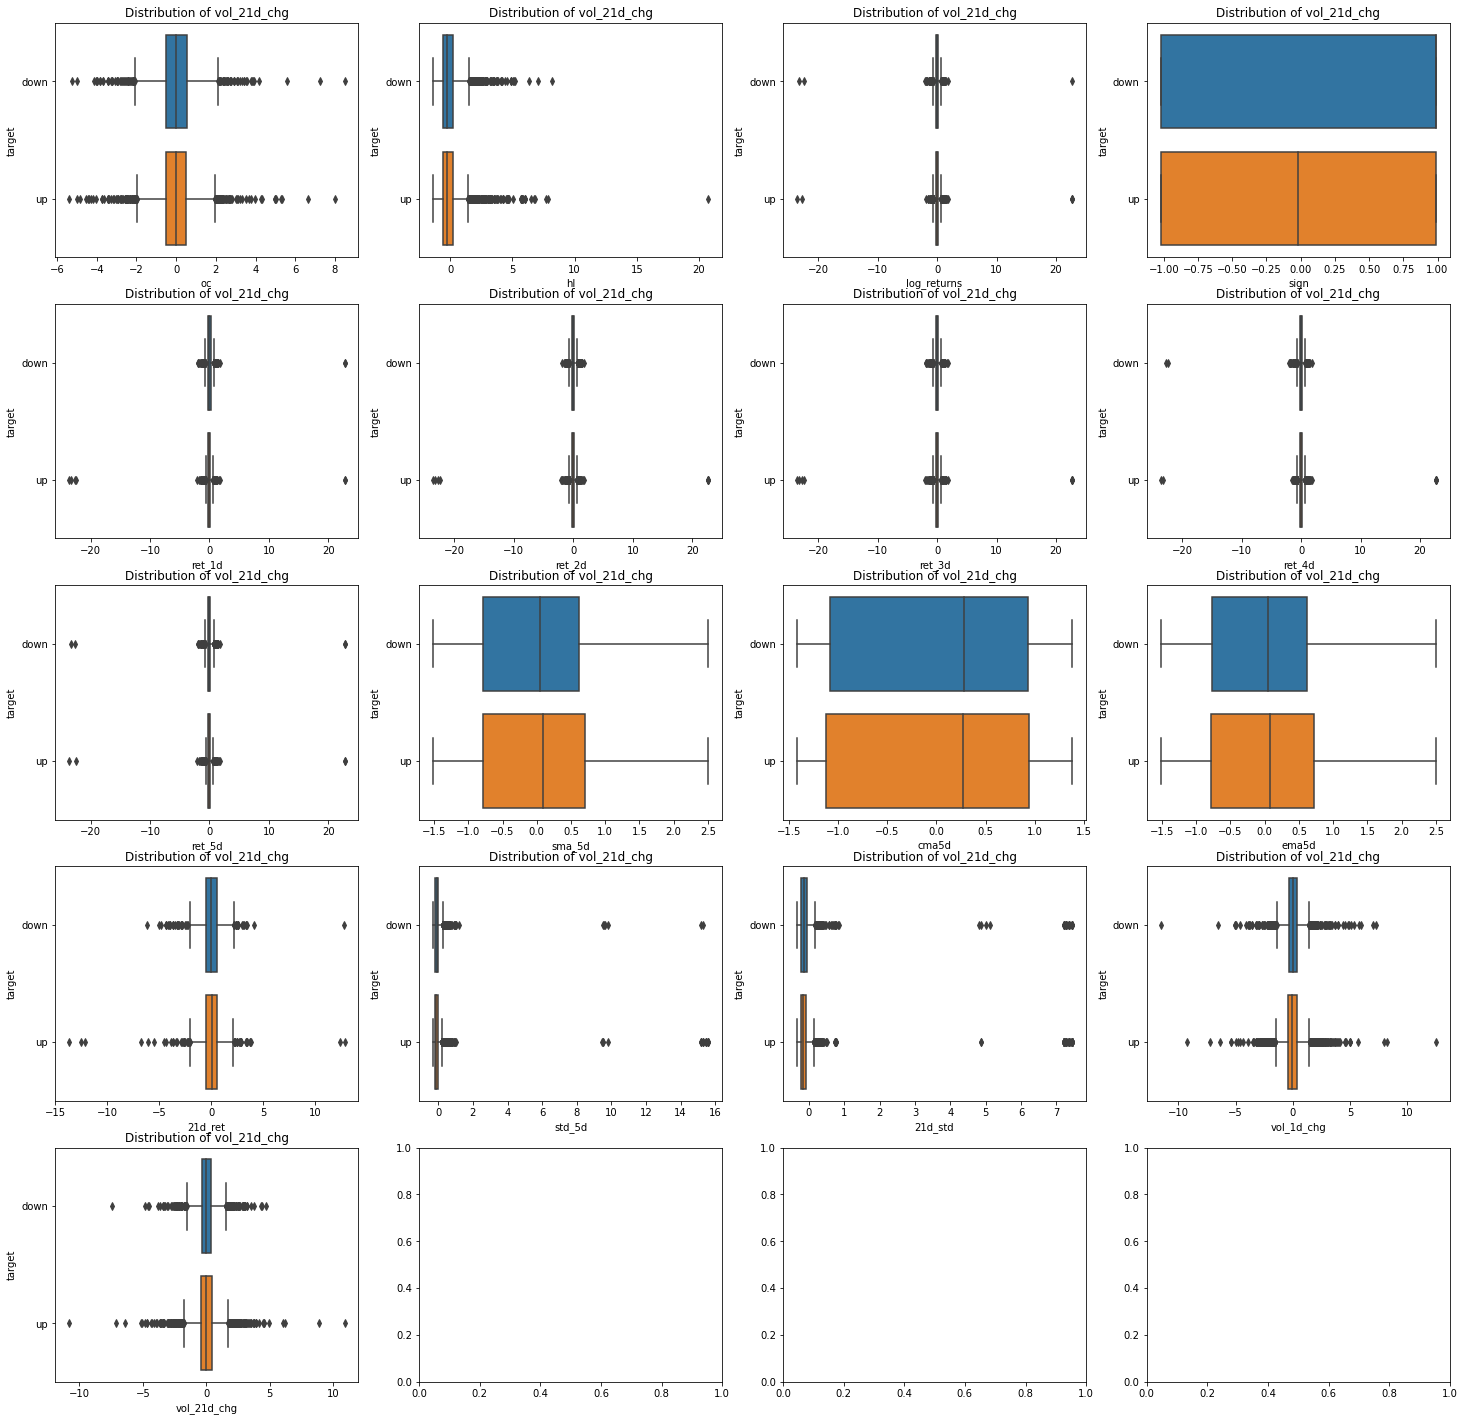

In [140]:
fig= plt.figure(figsize=(25,25))
gs= GridSpec(5,4,figure= fig)

a=1
axes_list=[]
for i in range(5):
    for j in range(4):
        axes= 'ax'+str(a)
        axes= fig.add_subplot(gs[i,j])
        axes_list.append(axes)
        a=a+1
        
for num in range(len(list(train_x_std.columns))-1):
    sns.boxplot(ax= axes_list[num],data= train_x_std,x= list(train_x_std.columns)[num], y='target')
    axes_list[num].title.set_text('Distribution of' + ' '+ col)

## Feature Selection using Filter, Wrapper and Embedded Methods
### Correlation Analysis (Filter Method)

**Procedure**
<br>
* As a part of the correlation analysis, we first look at the correlation among all the independent variables.
<br>
<br>
* We then look set a Threshold of 0.5 and isolate the features with correlation value greater than the threhsold value.
<br>
<br>
* We then look at the correlation value of the isolated feartures and the target value using the point biserial test.

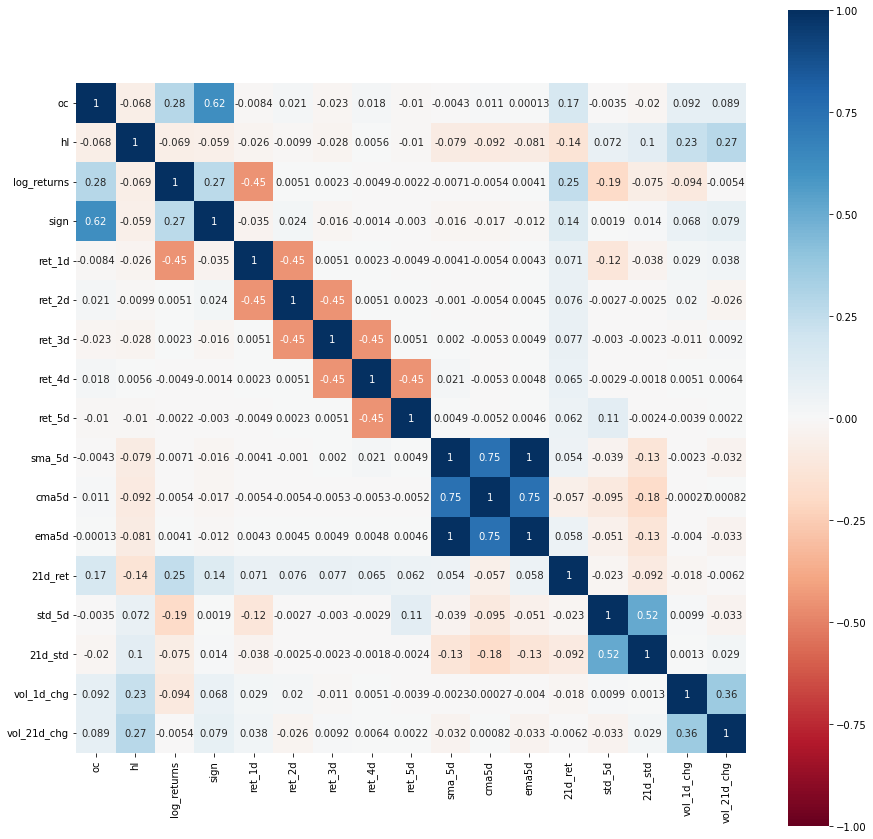

In [106]:
tr_corr= train_x_std.corr()

plt.figure(figsize=(15,15))
sns.heatmap(tr_corr, cmap='RdBu', vmin=-1, vmax=1,annot=True, square=True)
plt.show()

In [107]:
corr_matrix= train_x_std.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.50)]

print("Columns with Correlation more than the set Threshold of 0.5: ", to_drop)

Columns with Correlation more than the set Threshold of 0.5:  ['sign', 'cma5d', 'ema5d', '21d_std']


In [108]:
train_x_std['target']= tr_y
test_x_std['target']= te_y

#### Checking the Correaltion of the isolated variables with high correlation with the Target Variable

In [46]:
print("Point Biserial for Sign and Target Variables:\n", stats.pointbiserialr(train_x_std['sign'], train_x_std['target']))
print('\n')
print("Point Biserial for Cma5d and Target Variables:\n", stats.pointbiserialr(train_x_std['cma5d'], train_x_std['target']))
print('\n')
print("Point Biserial for ema5d and Target Variables:\n", stats.pointbiserialr(train_x_std['ema5d'], train_x_std['target']))
print('\n')
print("Point Biserial for 21d_std and Target Variables:\n", stats.pointbiserialr(train_x_std['21d_std'], train_x_std['target']))

Point Biserial for Sign and Target Variables:
 PointbiserialrResult(correlation=0.02714923157493522, pvalue=0.0637732920405158)


Point Biserial for Cma5d and Target Variables:
 PointbiserialrResult(correlation=-0.023442867665789582, pvalue=0.10946238598901073)


Point Biserial for ema5d and Target Variables:
 PointbiserialrResult(correlation=-0.022223970351885478, pvalue=0.12917324964936217)


Point Biserial for 21d_std and Target Variables:
 PointbiserialrResult(correlation=-0.001997677988509623, pvalue=0.8915229963795135)


### Variance Inflation Factor to target multicollinearity (Filter Method)

**Prcedure**
<br>
<br>
* VIF picks One independent variable and treats it as a dependent variable then runs a regression model on all the other independent variables and picked independent feature. 
<br>
<br>
* The r-sqaured value from the regression signifies the variance caputured by all the other independent variable and picked independent varibale.
<br>
<br>
* High value of VIF for a particular independent variable indictaes that the information added by the indenpendent variable to the overall dataset is very low.
<br>
<br>
$$ VIF= \frac{1}{1-R^2} $$ where $R^2$ coefficient of determination and it captures the variance in the dependent variable explanined by the independent variable

In [59]:
def compute_vif(df,considered_features):
    
    X = df[considered_features]
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [60]:
vif_cols= ['oc', 'hl', 'log_returns', 'sign', 'ret_1d', 'ret_2d', 'ret_3d',
       'ret_4d', 'ret_5d', 'sma_5d', 'cma5d', 'ema5d', '21d_ret', 'std_5d',
       '21d_std', 'vol_1d_chg', 'vol_21d_chg']

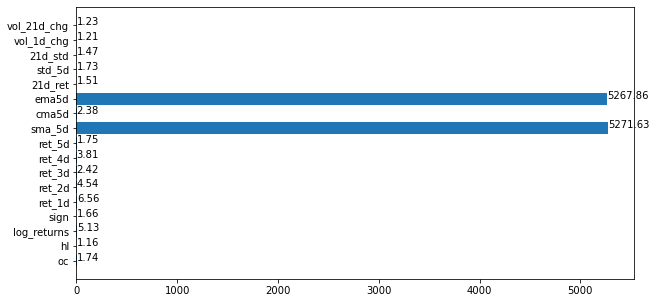

In [61]:
vif_df= compute_vif(train_x_std,vif_cols) 
vif_df['log_vif']= np.log(vif_df['VIF'])
vif_df['VIF']= np.round(vif_df['VIF'],2)

plt.figure(figsize=(10,5))
plt.barh(vif_df['Variable'],vif_df['VIF'])

for index,value in enumerate(vif_df['VIF']):
    plt.text(value, index,str(value))
plt.show()

**Plot Description and Observations:**
<br>
* VIF scores for each of the Independent variables with the name of the independent varaible on the x-axis and the VIF score on the Y-axis.

#### Filtering and displaying the results with high VIF (Threshold,">3")

* The below is a set of filtered independent variables with high multicollinearity greater than the chosen threshold (commonly used threshold across the industry).

In [62]:
mulc_df= vif_df[vif_df['VIF']>3].sort_values(by=['VIF'], ascending=False)
mulc_df

,Variable,VIF,log_vif
9,sma_5d,5271.63,8.570095
11,ema5d,5267.86,8.569379
4,ret_1d,6.56,1.880705
2,log_returns,5.13,1.635403
5,ret_2d,4.54,1.512451
7,ret_4d,3.81,1.337536


In [63]:
train_x_std.drop(['target'],axis=1,inplace=True)
test_x_std.drop(['target'],axis=1,inplace=True)

### Recursive Feature Elimination (Wrapper Method)

* RFE (Recursive Feature Elimination) recrusively removes features, build a model and calculates the evaluation metric of the model.
<br>
* In the current RFE, we are using Random Forest classifier as the base estimator. Hence,RFE uses the feature importance scores in order to recursively elimiate certain features.

In [64]:
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(3, shuffle= False), scoring='precision')

rfecv.fit(train_x_std,train_y)

print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 12


In [65]:
rfecv.ranking_

array([4, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 5, 1, 2, 3, 1, 1])

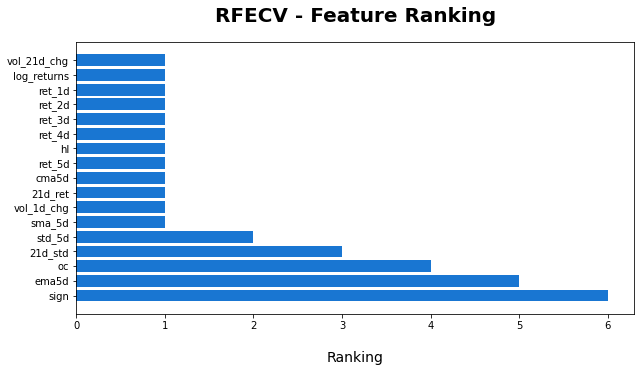

In [66]:
refcv_df = pd.DataFrame()
refcv_df['col_names'] = train_x_std.columns
refcv_df['rfe_feat_ranking'] = rfecv.ranking_

refcv_df = refcv_df.sort_values(by='rfe_feat_ranking', ascending=False)

plt.figure(figsize=(10,5))
plt.barh(y=refcv_df['col_names'], width=refcv_df['rfe_feat_ranking'], color='#1976D2')
plt.title('RFECV - Feature Ranking', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Ranking', fontsize=14, labelpad=20)
plt.show()

**Plot Description and Observations:**
<br>
* The plot above captures on the x-axis, the Ranking of each of the features based on the RFE evaluations and the name of the features on the y-axis.
<br>
* Each of the features is assigned a rank with 1 being the best rank and 6 being the highest rank.
<br>
* As shown in the figure, multiple features could be assigned the same rank, 12 features have been assigned Rank 1.

### Use of L1 regularization in Logistic regression to estimate feature co-efficients

* L2 Regularization is an addition to the loss function of a Logistic Regression in order to decrease the overfitting caused by the minimization of the loss function.
<br>
$$ L= \sum_{i}^{n}(y_{i}-h{\theta}(x_{i}))^2 + \lambda\sum_{i}^{n}|\theta|$$
<br>
* Where $\lambda$ is the regularization factor and $\theta_{i}$ is the weight vector
<br>
* Since we differentiate the L1 loss function in order to get to the minimum of the loss function and the absolute value of the $\theta$ when differentiated arrives to zero quicker than L2 regularization. Hence, certain co-efficients arrive to zero faster thus doing feature selection.


In [68]:
from sklearn.linear_model import LogisticRegression

lr_cw = LogisticRegression(solver='liblinear',penalty='l2')
lr_cw.fit(train_x_std, train_y)

LogisticRegression(solver='liblinear')

In [69]:
pred_proba= pd.DataFrame(lr_cw.predict_proba(test_x_std))
pred_proba.columns= ['zero_prob','one_prob']
pred_proba['actual']= test_y
pred_proba['predict']= np.zeros(pred_proba.shape[0])
pred_proba.loc[pred_proba['one_prob']>0.5,'predict']=1

The Weighted Recall Score:  0.9168975069252078
The Weighted Precision Score:  0.6198501872659176
The Weighted F1 Score:  0.7396648044692736
============================== Confusion matrix ==============================


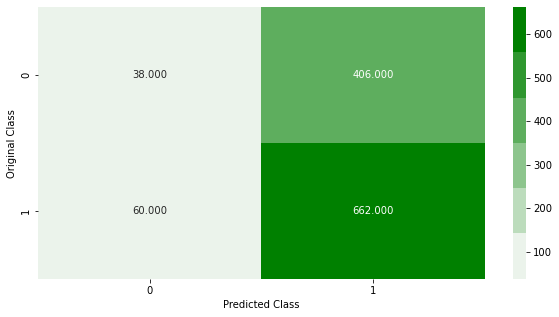

In [116]:
C = confusion_matrix(pred_proba['actual'],pred_proba['predict'])
print("The Weighted Recall Score: ",recall_score(pred_proba['actual'],pred_proba['predict']))
print("The Weighted Precision Score: ",precision_score(pred_proba['actual'],pred_proba['predict']))
print("The Weighted F1 Score: ",f1_score(pred_proba['actual'],pred_proba['predict']))

print("="*30, "Confusion matrix", "="*30)
labels = [0,1]
cmap=sns.light_palette("green")
plt.figure(figsize=(10,5))
sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

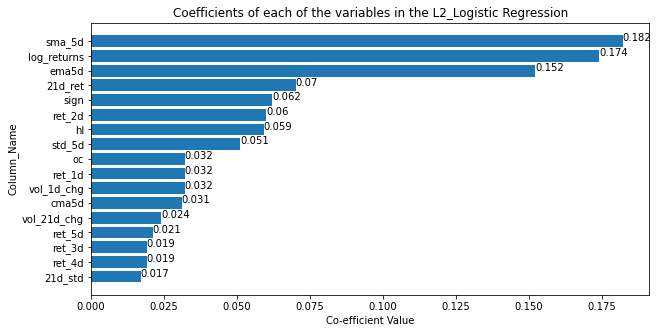

In [70]:
l2coeff_df= pd.DataFrame()
l2coeff_df['col_names']= list(train_x_std.columns)
l2coeff_df['coeff']= np.round(list(np.abs(lr_cw.coef_[0])),3)
l2coeff_df.sort_values(by=['coeff'],ascending=True,inplace=True)


plt.figure(figsize=(10,5))
plt.barh(l2coeff_df['col_names'],l2coeff_df['coeff'])

for index,value in enumerate(l2coeff_df['coeff']):
    plt.text(value, index,str(value))
    
plt.xlabel('Co-efficient Value')
plt.ylabel('Column_Name')
plt.title('Coefficients of each of the variables in the L2_Logistic Regression')
plt.show()

**Plot Description and Observations:**
<br>
* The plot above captures on the x-axis, the co-efficient value of each of the features based on the L2 regularizations and the name of the features on the y-axis.
<br>
* Smaller value of the co-efficient signifies that the feature is less important and vice-versa
<br>
* As shown in the figure, all the fetures are sorted based on the co-efficient values

### Use of Random Forests and evaluate the Feature Importance

* Random Forests has an in-built feature importance attribute that gives it the scores for feature importance

The Weighted Recall Score:  0.6052631578947368
The Weighted Precision Score:  0.6260744985673352
The Weighted F1 Score:  0.6154929577464788
============================== Confusion matrix ==============================


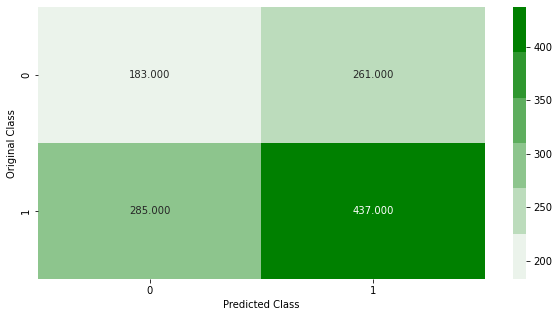

In [71]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

rf.fit(train_x_std,train_y)

rf_pred_prob= rf.predict_proba(test_x_std)

rf_prba= pd.DataFrame(rf_pred_prob)
rf_prba.columns= ['zero_prob','one_prob']
rf_prba['actual']= test_y
rf_prba['predict']= np.zeros(rf_prba.shape[0])
rf_prba.loc[rf_prba['one_prob']>0.5,'predict']=1

C_rf = confusion_matrix(rf_prba['actual'],rf_prba['predict'])
print("The Weighted Recall Score: ",recall_score(rf_prba['actual'],rf_prba['predict']))
print("The Weighted Precision Score: ",precision_score(rf_prba['actual'],rf_prba['predict']))
print("The Weighted F1 Score: ",f1_score(rf_prba['actual'],rf_prba['predict']))

print("="*30, "Confusion matrix", "="*30)
labels = [0,1]
cmap=sns.light_palette("green")
plt.figure(figsize=(10,5))
sns.heatmap(C_rf, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

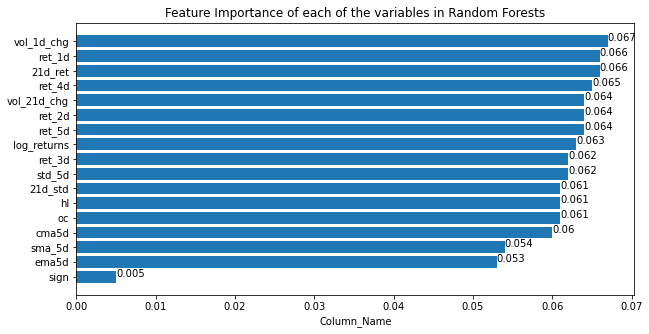

In [72]:
rfimp_df= pd.DataFrame()
rfimp_df['col_names']= list(train_x_std.columns)
rfimp_df['feat_imp']= np.round(rf.feature_importances_,3)
rfimp_df.sort_values(by='feat_imp',ascending=True,inplace=True)

plt.figure(figsize=(10,5))
plt.barh(rfimp_df['col_names'],rfimp_df['feat_imp'])

for index,value in enumerate(rfimp_df['feat_imp']):
    plt.text(value, index,str(value))
    
plt.xlabel('Feature Importance Value')
plt.xlabel('Column_Name')
plt.title('Feature Importance of each of the variables in Random Forests')
plt.show()

**Plot Description and Observations:**
<br>
* The plot above captures on the x-axis, the feature importance score of each of the features as given out by the Random Forests classifier.
<br>
* Smaller value of the feature importance scores signifies that the feature is less important and vice-versa

In [73]:
vif_df.drop('log_vif',axis=1,inplace=True)
vif_df.rename(columns={'Variable':'col_names'},inplace=True)
l2coeff_df.rename(columns={'coeff':'l2_coeff'},inplace=True)
rfimp_df.rename(columns={'feat_imp':'rf_feat_imp'},inplace=True)

In [74]:
fimp_consdf= vif_df.merge(l2coeff_df,how='inner',on=['col_names'])
fimp_consdf= fimp_consdf.merge(rfimp_df,how='inner',on=['col_names'])
fimp_consdf= fimp_consdf.merge(refcv_df,how='inner',on=['col_names'])

In [75]:
fimp_consdf.columns= fimp_consdf.columns.str.lower()

In [76]:
train_x_std['target']= train_y
test_x_std['target']= test_y

### Summary of the Feature Importance Results from various Methods

In [77]:
print("Correlation of the highly correlated Independent variables (as obtained from correlation maps) with the Target Variable")
print('\n')
print("Point Biserial for Sign and Target Variables:\n", stats.pointbiserialr(train_x_std['sign'], train_x_std['target']))
print('\n')
print("Point Biserial for Cma5d and Target Variables:\n", stats.pointbiserialr(train_x_std['cma5d'], train_x_std['target']))
print('\n')
print("Point Biserial for ema5d and Target Variables:\n", stats.pointbiserialr(train_x_std['ema5d'], train_x_std['target']))
print('\n')
print("Point Biserial for 21d_std and Target Variables:\n", stats.pointbiserialr(train_x_std['21d_std'], train_x_std['target']))
print('\n')
print("=="*50)


Correlation of the highly correlated Independent variables (as obtained from correlation maps) with the Target Variable


Point Biserial for Sign and Target Variables:
 PointbiserialrResult(correlation=0.02714923157493522, pvalue=0.0637732920405158)


Point Biserial for Cma5d and Target Variables:
 PointbiserialrResult(correlation=-0.023442867665789582, pvalue=0.10946238598901073)


Point Biserial for ema5d and Target Variables:
 PointbiserialrResult(correlation=-0.022223970351885478, pvalue=0.12917324964936217)


Point Biserial for 21d_std and Target Variables:
 PointbiserialrResult(correlation=-0.001997677988509623, pvalue=0.8915229963795135)




In [ ]:
print("Feature Importance score of VIF method, L2_logsitic and Random_Forests Methods")
print(tabulate(fimp_consdf, headers = 'keys', tablefmt = 'fancy_grid'))

### Feature Importance score of VIF method, RFE, L2_logsitic and Random_Forests Methods

<Figure size 3600x3600 with 0 Axes>

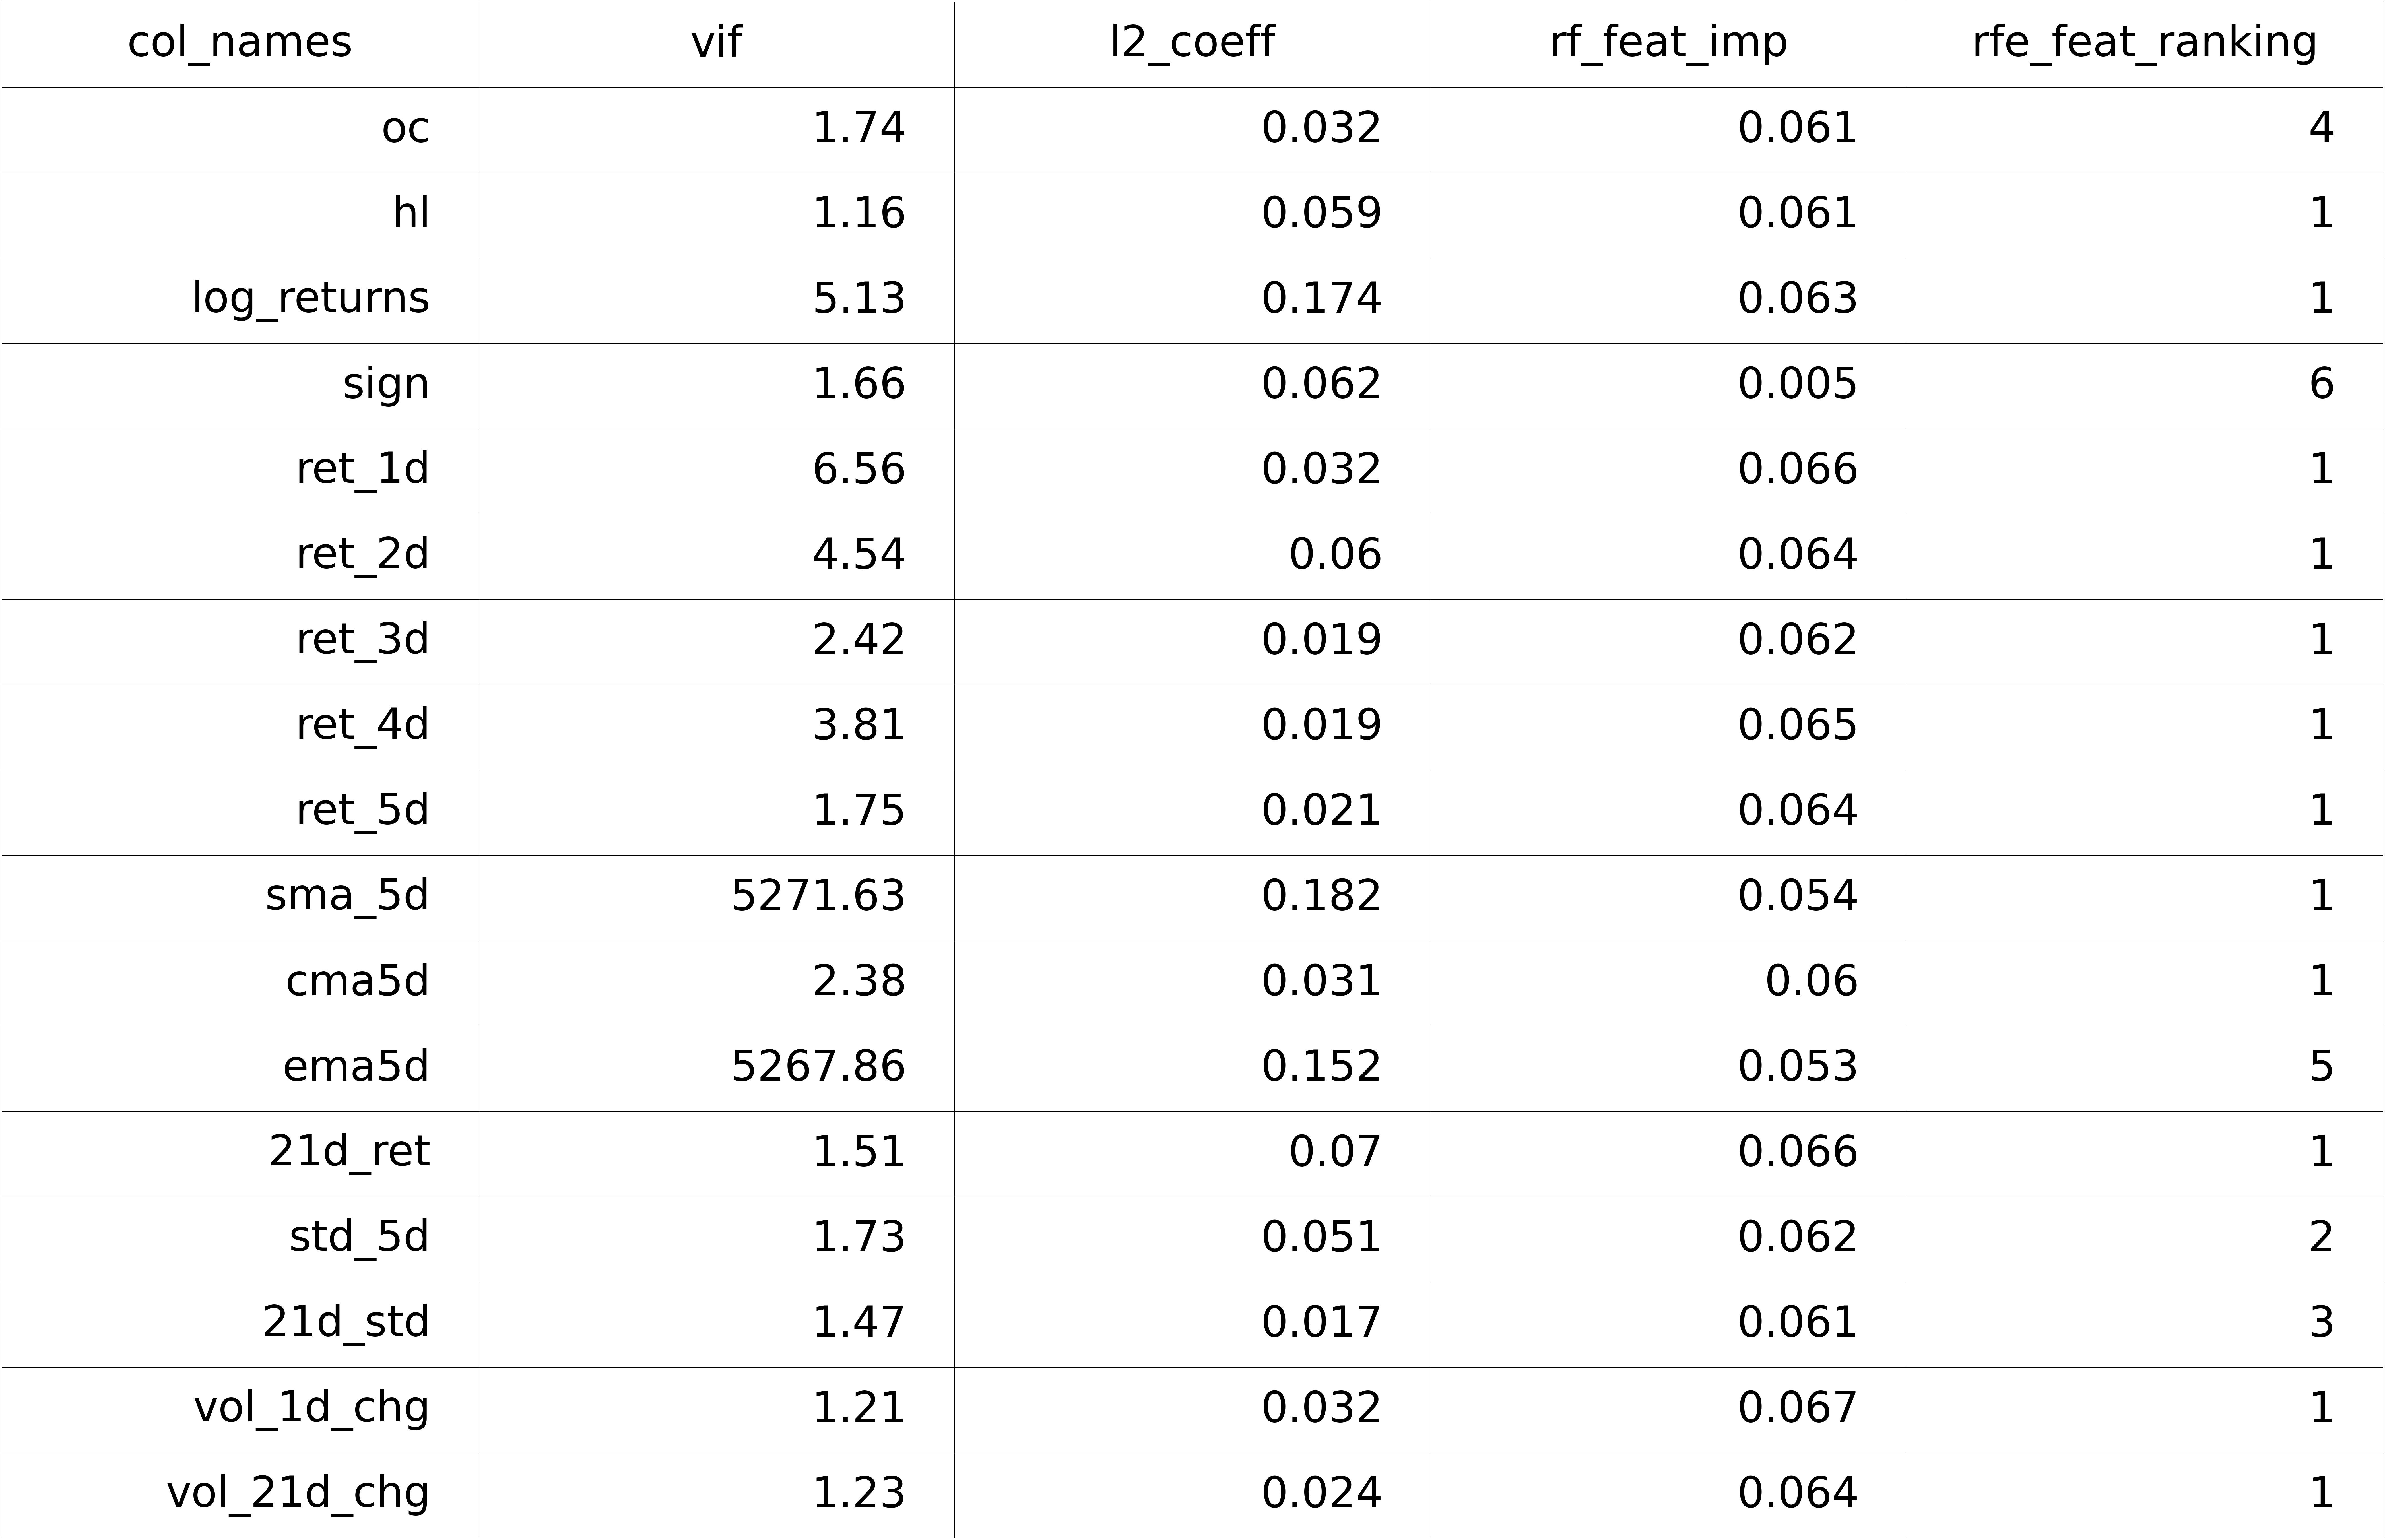

In [79]:
plt.figure(figsize=(50,50))
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


#create table
table = ax.table(cellText=fimp_consdf.values, colLabels=fimp_consdf.columns, loc='center')

#modify table
table.set_fontsize(150)
table.scale(25,25)
ax.axis('off')

#display table
plt.show()

### Level 1: Eliminating Features based on the above summary table based on the correlation, VIF, L1 Regularization and Random Forests

* Dropping ema5d as it has a very high VIF score of 5267.86 (which is about 0.99 R-Squared.VIF on ema5d feature runs a regression model on all the other independent variables and the ema5d feature. 
<br>
<br>
* The r-sqaured value from the regression signifies the variance caputured by all the other independent variable and ema5d thus signifying that the variable ema5d does not add much information to the overall dataset. 
<br>
<br>
* In addition the high VIF score, ema5d variable also has a low correlation value as signified by the p-value in the result of the Point-Biserial test which is 0.129. 
<br>
<br>
* P-value of more than 0.05 signifies that the correlation seen between ema5d and the taget varible is only by chance thus confirming the the Null Hypothesis (both the variables are independent of each other).
<br>
<br>
* Moreover, the feature importance score from the Random Forests for ema5d variable is low compared to other variables.
<br>
<br>
* All the above reasons add more reasons to drop  the ema5d variable as the variable is not adding any additional information to the model in order to make a classification
<br>
<br>
* Dropping the sign and sma_5d columns as well for the same reasons cited above.

In [23]:
train_x_l1= train_x_std.drop(['ema5d','sign','sma_5d'], axis=1)
test_x_l1= test_x_std.drop(['ema5d','sign','sma_5d'], axis=1)

# Section B

### Building an SVM Model with Default Parameters and without dropping any features

In [17]:
def hyperparam_tune(x_train,y_train,param_grid,cv):
    svc_classifier = SVC(probability=True)
    halving_cv = HalvingGridSearchCV(svm_classifier, param_grid, scoring="f1", n_jobs=-1, min_resources="exhaust", factor=3)
    halving_cv.fit(train_x_l2,train_y)
    
    print("Best parameters after hyperparameter Tuning: ",halving_cv.best_params_)
    print("Best Score after hyperparameter Tuning: ",halving_cv.best_score_)

In [18]:
def conf_matrix(x_train,y_train,x_test,y_test,model):
    train_pred_prob= model.predict_proba(x_train)
    train_pred_prob_df= pd.DataFrame(train_pred_prob)
    train_pred_prob_df.columns= ['zero_prob','one_prob']
    train_pred_prob_df['actual']= y_train
    train_pred_prob_df['predict']= np.zeros(train_pred_prob_df.shape[0])
    train_pred_prob_df.loc[train_pred_prob_df['one_prob']>0.5,'predict']=1

    C_svm_train = confusion_matrix(train_pred_prob_df['actual'],train_pred_prob_df['predict'])
    train_recall_score= recall_score(train_pred_prob_df['actual'],train_pred_prob_df['predict'])
    train_precision_score= precision_score(train_pred_prob_df['actual'],train_pred_prob_df['predict'])
    train_f1_score= f1_score(train_pred_prob_df['actual'],train_pred_prob_df['predict'])
    
    print("Train Recall Score: ",train_recall_score)
    print("Train Precision Score: ",train_precision_score)
    print("Train F1 Score: ",train_f1_score)
    print("=="*35)
    
    train_dict= {'recall':train_recall_score,'precision':train_precision_score,'f1_score':train_f1_score}
    
    test_pred_prob= model.predict_proba(x_test)
    test_pred_prob_df= pd.DataFrame(test_pred_prob)
    test_pred_prob_df.columns= ['zero_prob','one_prob']
    test_pred_prob_df['actual']= y_test
    test_pred_prob_df['predict']= np.zeros(test_pred_prob_df.shape[0])
    test_pred_prob_df.loc[test_pred_prob_df['one_prob']>0.5,'predict']=1

    C_svm_test = confusion_matrix(test_pred_prob_df['actual'],test_pred_prob_df['predict'])
    
    test_recall_score= recall_score(test_pred_prob_df['actual'],test_pred_prob_df['predict'])
    test_precision_score= precision_score(test_pred_prob_df['actual'],test_pred_prob_df['predict'])
    test_f1_score= f1_score(test_pred_prob_df['actual'],test_pred_prob_df['predict'])
    
    print("Test Recall Score: ",test_recall_score)
    print("Test Precision Score: ",test_precision_score)
    print("Test F1 Score: ",test_f1_score)
    print("=="*35)
    
    train_auc = roc_auc_score(train_pred_prob_df['actual'], train_pred_prob_df['one_prob'])
    train_fpr, train_tpr, train_thresh = roc_curve(train_pred_prob_df['actual'], train_pred_prob_df['one_prob'])
    
    test_auc = roc_auc_score(test_pred_prob_df['actual'], test_pred_prob_df['one_prob'])
    test_fpr, test_tpr, test_thresh = roc_curve(test_pred_prob_df['actual'], test_pred_prob_df['one_prob'])
    
    train_dict= {'recall':train_recall_score,'precision':train_precision_score,'f1_score':train_f1_score,'auc':train_auc}
    test_dict= {'recall':test_recall_score,'precision':test_precision_score,'f1_score':test_f1_score,'auc':train_auc}
    
    print("=="*35)
    print("Train AUC_Score: {}".format(train_auc))
    print("Test AUC_Score: {}".format(test_auc))
    
    fig= plt.figure(figsize=(25,25))
    gs= GridSpec(3,2,figure= fig)
    ax1= fig.add_subplot(gs[0,0])
    ax2= fig.add_subplot(gs[0,1])
    ax3= fig.add_subplot(gs[1,0])
    ax4= fig.add_subplot(gs[1,1])
    ax5= fig.add_subplot(gs[2,0])
    ax6= fig.add_subplot(gs[2,1])
    
    labels = [0,1]
    cmap=sns.light_palette("green")
    plt.figure(figsize=(10,5))
    sns.heatmap(C_svm_train, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels,ax=ax1)
    ax1.set_xlabel('Predicted Class')
    ax1.set_ylabel('Original Class')
    ax1.set_title("Train Confusion Matrix")
    
    labels = [0,1]
    cmap=sns.light_palette("green")
    plt.figure(figsize=(10,5))
    sns.heatmap(C_svm_test, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels,ax=ax2)
    ax2.set_xlabel('Predicted Class')
    ax2.set_ylabel('Original Class')
    ax2.set_title("Test Confusion Matrix")

    sns.kdeplot(data=train_pred_prob_df, x= 'one_prob', color='green',ax=ax3)
    ax3.set_xlabel('Probability of UP Class')
    ax3.set_title('Probability Distritbution of Predicted Target values in Train Data')
    
    sns.kdeplot(data=test_pred_prob_df, x= 'one_prob', color='green', ax=ax4)
    ax4.set_xlabel('Probability of UP Class')
    ax4.set_title('Probability Distritbution of Predicted Target values in Test Data')
         
    ax5.plot(train_fpr, train_tpr, label='svm_model')
    ax5.set_xlabel('False Positive Rate')
    ax5.set_ylabel('True Positive Rate')
    ax5.set_title('Train_ROC_Curve')
    
    ax6.plot(test_fpr, test_tpr, label='svm_model')
    ax6.set_xlabel('False Positive Rate')
    ax6.set_ylabel('True Positive Rate')
    ax6.set_title('Test_ROC_Curve')
    
    plt.show()
    
    dicts_list=[train_dict,test_dict]
    results_df= pd.DataFrame(dicts_list)
    index_list= ['train','test']
    results_df.index= index_list
    
    return results_df



### Results of Train Data and Test Data of the SVM model with Default Paramters and without dropping any features

In [19]:
svm_default= SVC(probability=True)
svm_default.fit(train_x_std,train_y)

SVC(probability=True)

Train Recall Score:  1.0
Train Precision Score:  0.6174136821788548
Train F1 Score:  0.7634579687085654
Test Recall Score:  1.0
Test Precision Score:  0.6192109777015438
Test F1 Score:  0.7648305084745763
Train AUC_Score: 0.6827823484424866
Test AUC_Score: 0.4925725587082928


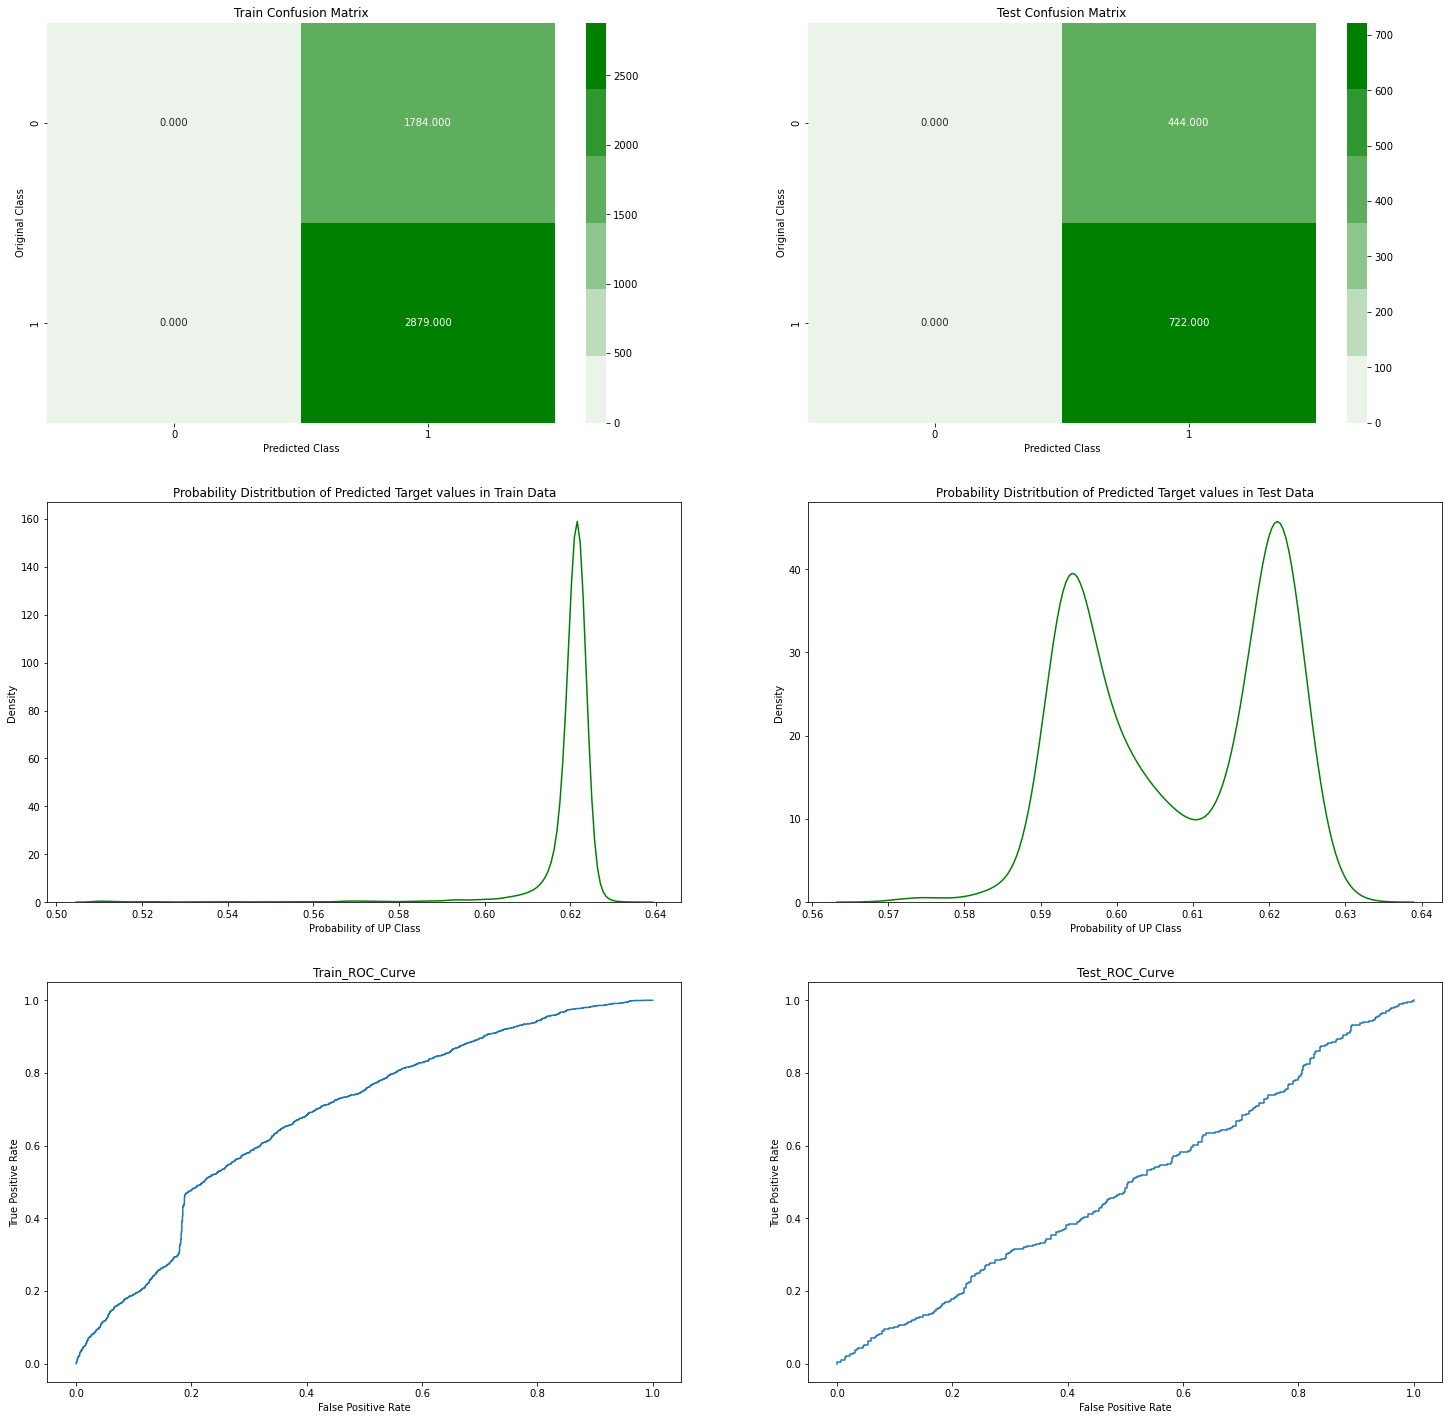

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [20]:
default_results= conf_matrix(train_x_std,train_y,test_x_std,test_y,svm_default)

In [21]:
default_results= default_results.add_prefix('dflt_params_')
default_results

,dflt_params_recall,dflt_params_precision,dflt_params_f1_score,dflt_params_auc
train,1.0,0.617414,0.763458,0.682782
test,1.0,0.619211,0.764831,0.682782


### Level 1 Hyperparameter Tuning of SVM Classifier after dropping 'ema5d','sign','sma_5d' columns

In [68]:
param_grid = {'C' : [0.0001, 0.001,0.01, 0.1,1],"gamma":[0.0001,0.001,0.1], "kernel": ['rbf', 'poly']}
hyperparam_tune(train_x_l1, train_y ,param_grid,5)

Best parameters after hyperparameter Tuning:  {'C': 0.01, 'gamma': 0.0001, 'kernel': 'poly'}
Best Score after hyperparameter Tuning:  0.7633504033460948


In [24]:
best_model_level1= SVC(probability=True,C= 0.01,gamma=0.0001,kernel='poly')
best_model_level1.fit(train_x_l1,train_y)

SVC(C=0.01, gamma=0.0001, kernel='poly', probability=True)

### Results of Train Data and Test Data of the fine tuned SVM model after dropping Level 1 feature selection

Train Recall Score:  1.0
Train Precision Score:  0.6174136821788548
Train F1 Score:  0.7634579687085654
Test Recall Score:  1.0
Test Precision Score:  0.6192109777015438
Test F1 Score:  0.7648305084745763
Train AUC_Score: 0.5168539150832454
Test AUC_Score: 0.5024706146589804


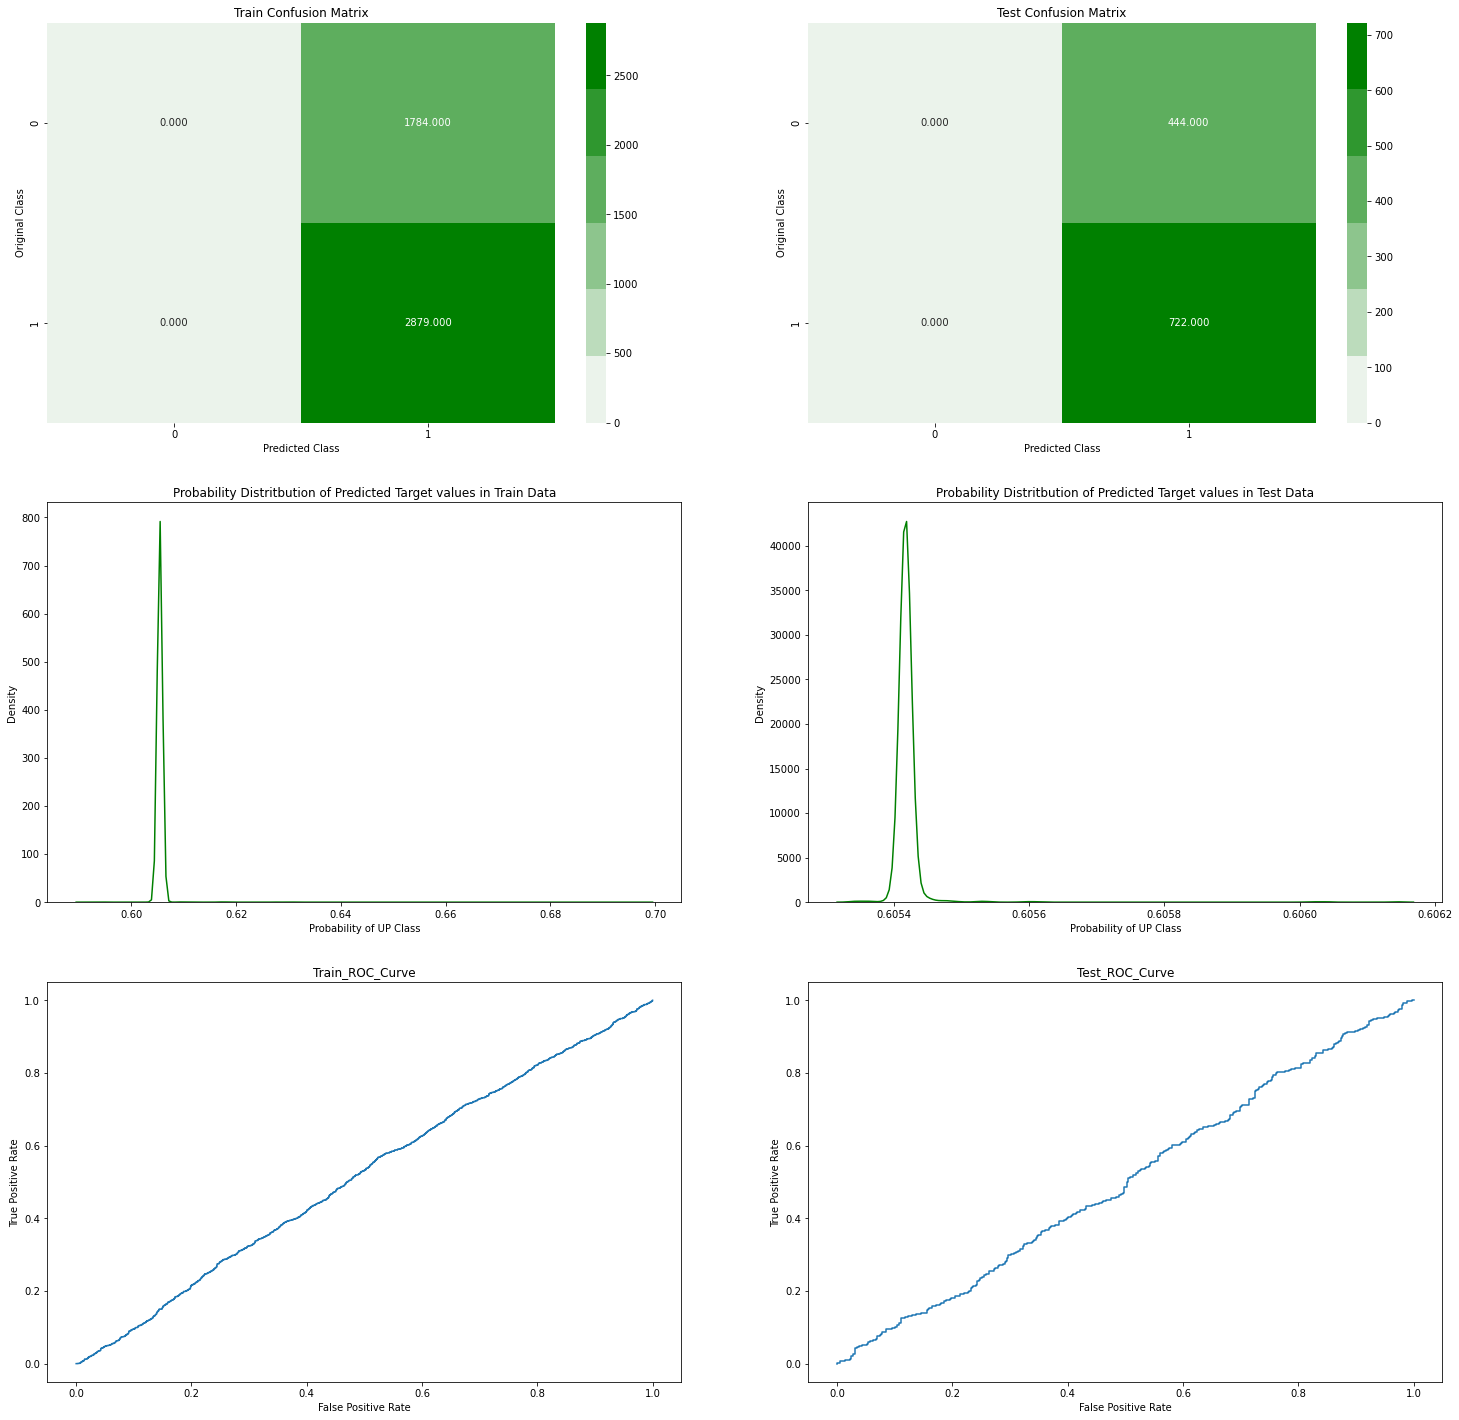

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [25]:
level1_results= conf_matrix(train_x_l1,train_y,test_x_l1,test_y,best_model_level1)

In [26]:
level1_results= level1_results.add_prefix('lvl1_')
level1_results

,lvl1_recall,lvl1_precision,lvl1_f1_score,lvl1_auc
train,1.0,0.617414,0.763458,0.516854
test,1.0,0.619211,0.764831,0.516854


### Level 2 Feature Selection

#### Dropping the Log_returns, ret_1d and ret_2d columns from the train and test datasets

In [27]:
train_x_l2= train_x_l1.drop(['log_returns', 'ret_1d', 'ret_2d'],axis=1)
test_x_l2= test_x_l1.drop(['log_returns', 'ret_1d', 'ret_2d'],axis=1)

In [19]:
train_x_l2.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'oc', 'hl',
       'ret_3d', 'ret_4d', 'ret_5d', 'cma5d', '21d_ret', 'std_5d', '21d_std',
       'vol_1d_chg', 'vol_21d_chg'],
      dtype='object')

### Level 2 Hyperparameter Tuning of SVM Classifier after dropping 'log_returns', 'ret_1d', 'ret_2d' columns

In [71]:
param_grid = {'C' : [0.0001, 0.001,0.01, 0.1,1],"gamma":[0.0001,0.001,0.1], "kernel": ['rbf', 'poly']}
hyperparam_tune(train_x_l2, train_y ,param_grid,5)

Best parameters after hyperparameter Tuning:  {'C': 0.01, 'gamma': 0.0001, 'kernel': 'poly'}
Best Score after hyperparameter Tuning:  0.7635150935870932


In [28]:
best_model_level2= SVC(probability=True,C= 0.01,gamma=0.0001,kernel='poly')
best_model_level2.fit(train_x_l2,train_y)

SVC(C=0.01, gamma=0.0001, kernel='poly', probability=True)

### Results of Train Data and Test Data of the fine tuned SVM model after dropping Level 2 feature selection

Train Recall Score:  1.0
Train Precision Score:  0.6174136821788548
Train F1 Score:  0.7634579687085654
Test Recall Score:  1.0
Test Precision Score:  0.6192109777015438
Test F1 Score:  0.7648305084745763
Train AUC_Score: 0.5088216122003
Test AUC_Score: 0.5315564872351576


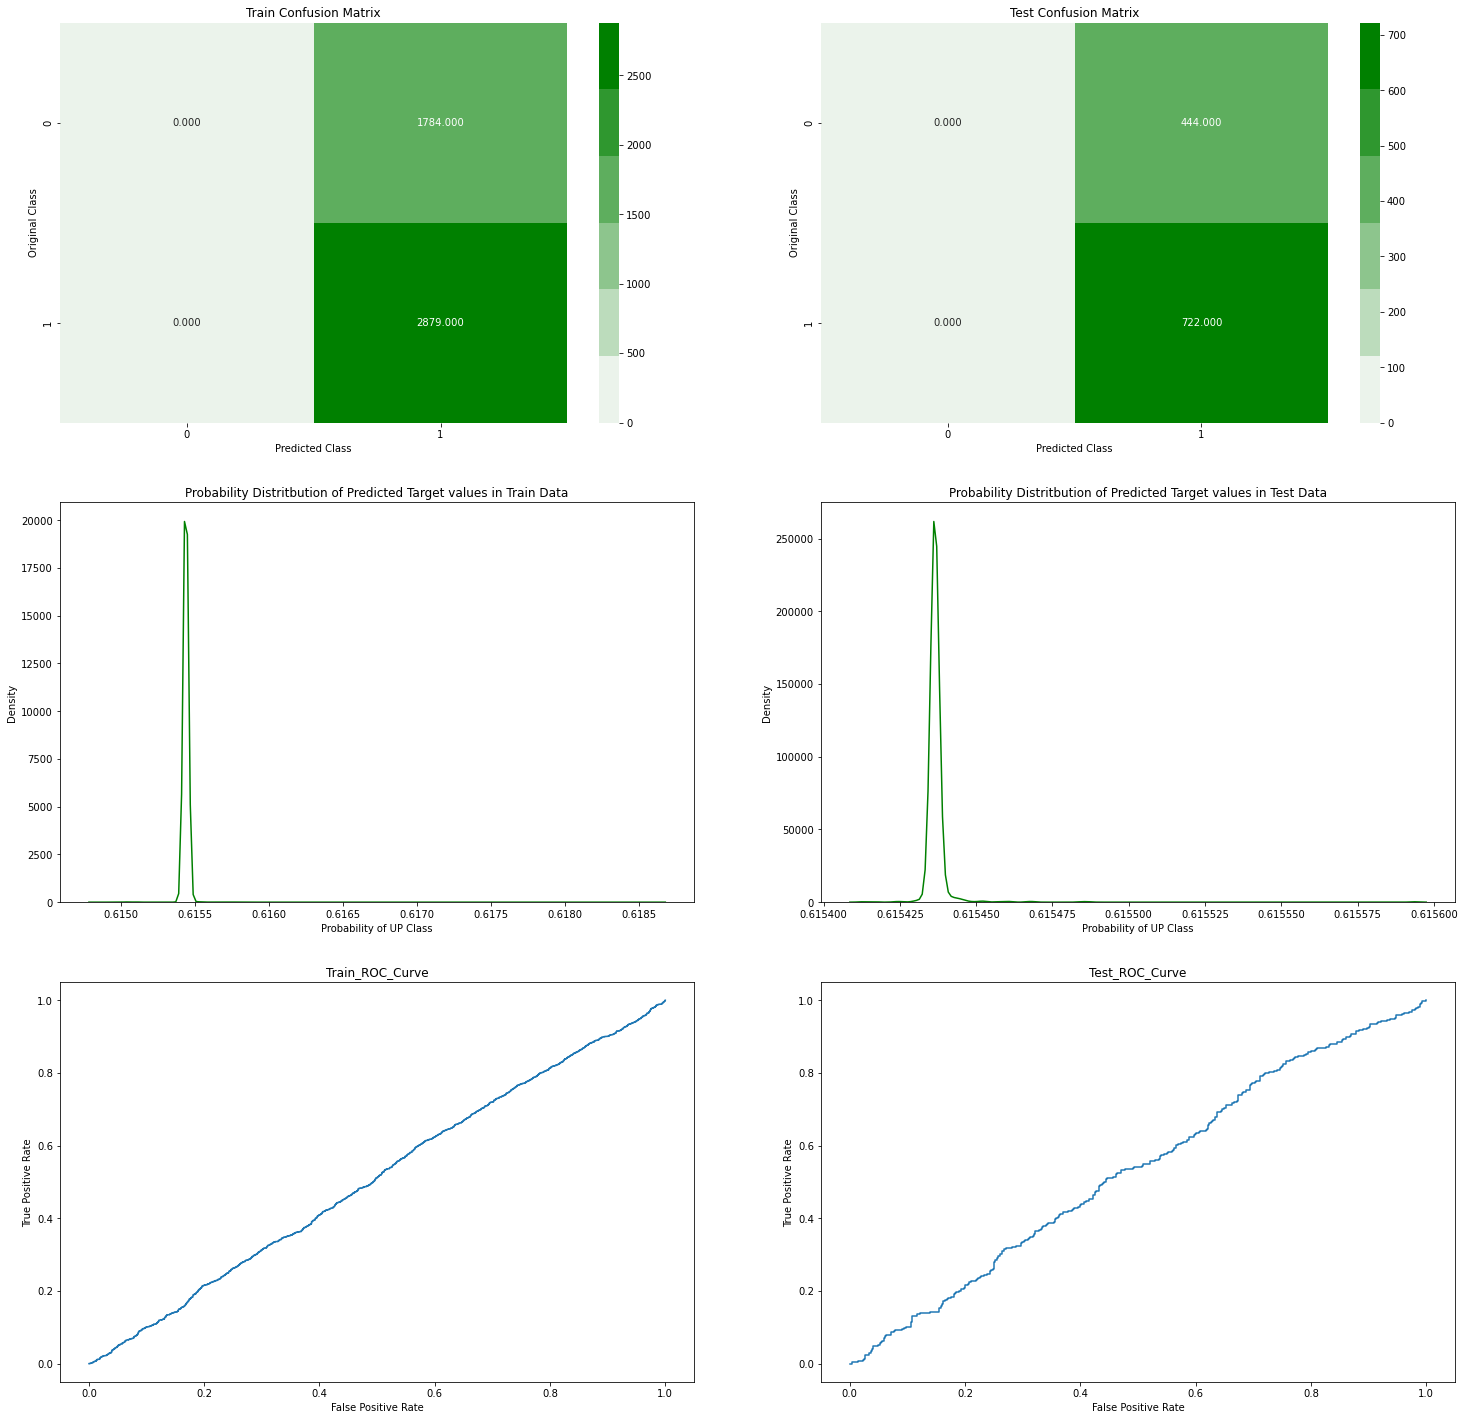

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [29]:
level2_results= conf_matrix(train_x_l2,train_y,test_x_l2,test_y,best_model_level2)

In [30]:
level2_results= level2_results.add_prefix('lvl2_')
level2_results

,lvl2_recall,lvl2_precision,lvl2_f1_score,lvl2_auc
train,1.0,0.617414,0.763458,0.508822
test,1.0,0.619211,0.764831,0.508822


### Level3 Feature Selection
#### Dropping the 21_std and OC feartures from the dataset

In [31]:
train_x_l3= train_x_l2.drop(['21d_std','oc'],axis=1)
test_x_l3= test_x_l2.drop(['21d_std','oc'],axis=1)

In [74]:
param_grid = {'C' : [0.0001, 0.001,0.01, 0.1,1],"gamma":[0.0001,0.001,0.1], "kernel": ['rbf', 'poly']}
hyperparam_tune(train_x_l3, train_y ,param_grid,5)

Best parameters after hyperparameter Tuning:  {'C': 0.01, 'gamma': 0.0001, 'kernel': 'poly'}
Best Score after hyperparameter Tuning:  0.7635150938231845


In [32]:
best_model_level3= SVC(probability=True,C= 0.01,gamma=0.0001,kernel='poly')
best_model_level3.fit(train_x_l3,train_y)

SVC(C=0.01, gamma=0.0001, kernel='poly', probability=True)

### Results of Train Data and Test Data of the fine tuned SVM model after dropping Level 3 feature selection

Train Recall Score:  1.0
Train Precision Score:  0.6174136821788548
Train F1 Score:  0.7634579687085654
Test Recall Score:  1.0
Test Precision Score:  0.6192109777015438
Test F1 Score:  0.7648305084745763
Train AUC_Score: 0.5086582598280108
Test AUC_Score: 0.5470134261685508


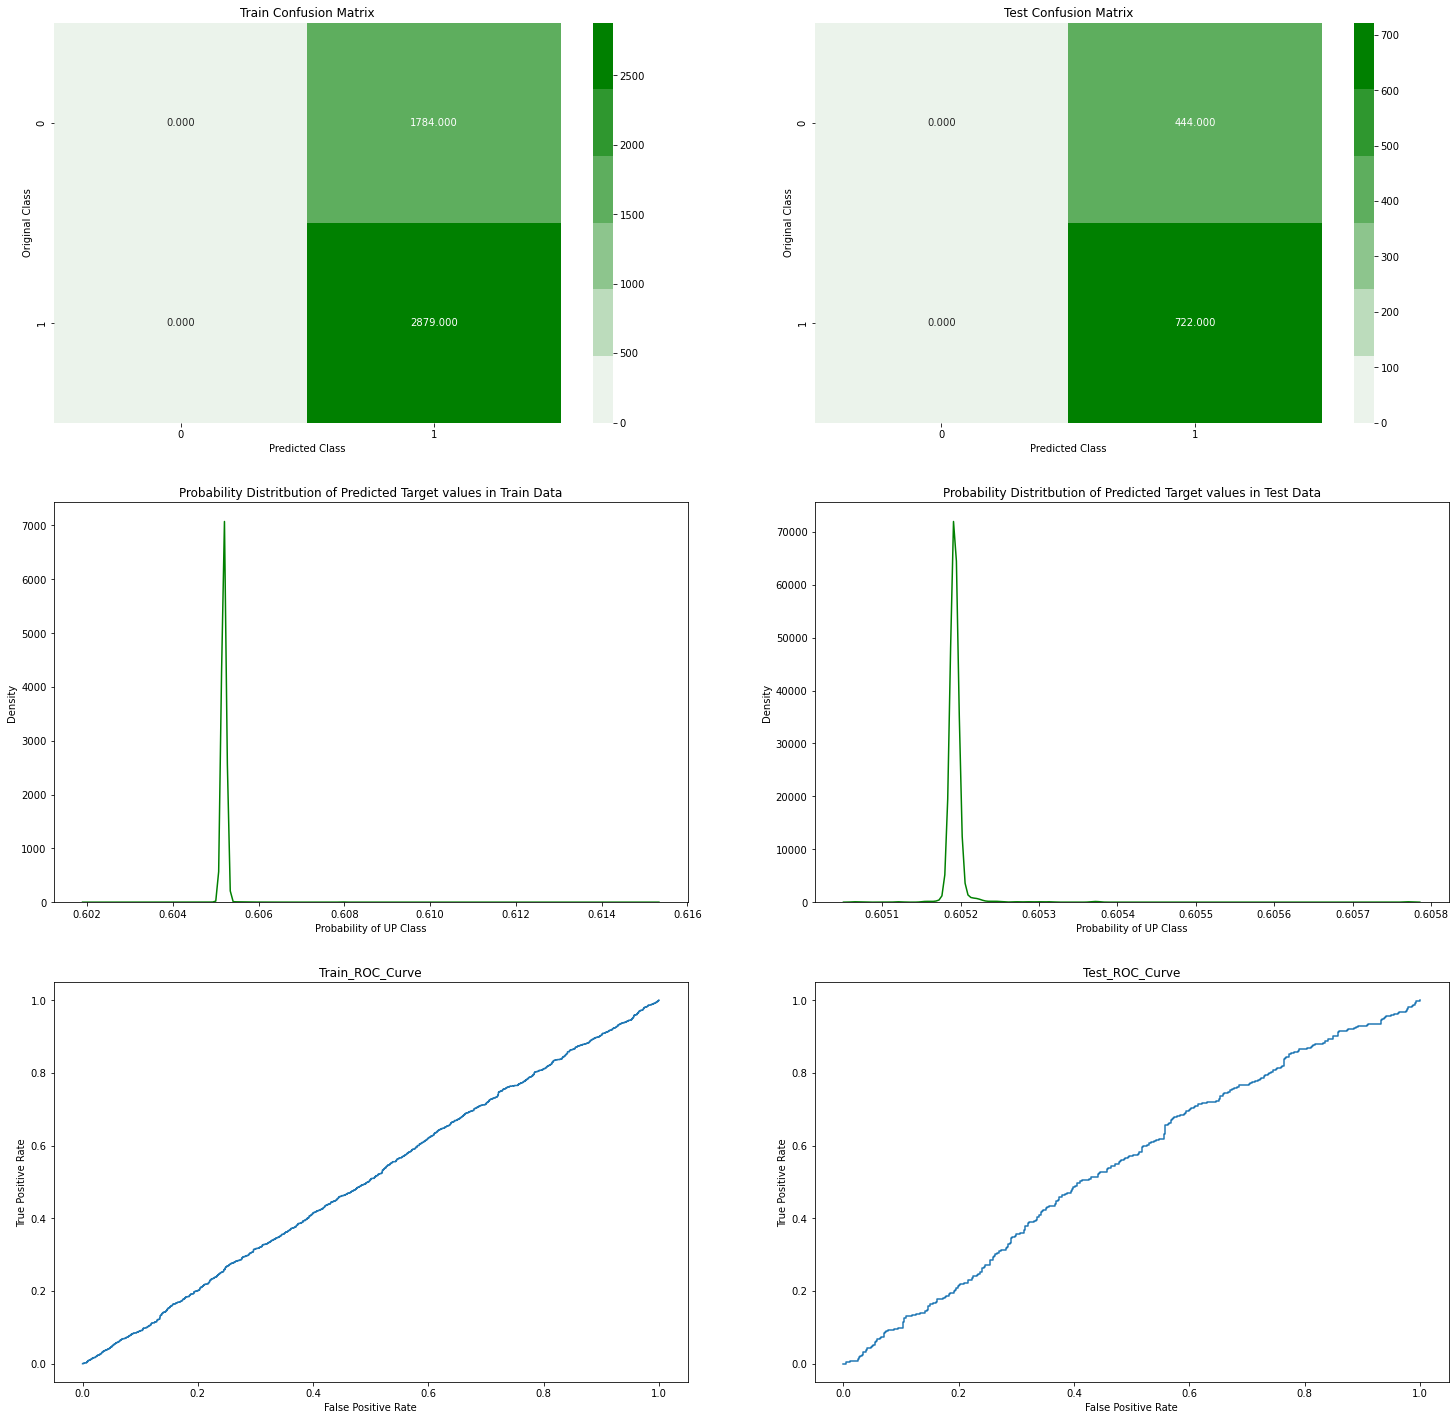

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [33]:
level3_results= conf_matrix(train_x_l3,train_y,test_x_l3,test_y,best_model_level3)

In [34]:
level3_results= level3_results.add_prefix('lvl3_')
level3_results

,lvl3_recall,lvl3_precision,lvl3_f1_score,lvl3_auc
train,1.0,0.617414,0.763458,0.508658
test,1.0,0.619211,0.764831,0.508658


In [35]:
res_list= [default_results,level1_results,level2_results,level3_results]
results_summary= pd.concat(res_list,axis=1)

results_summary= results_summary.transpose()
results_summary.reset_index(inplace=True)
results_summary.columns=['title','Train_Dataset','Test_Dataset']

results_summary['Evaluation_Metric']= np.nan
results_summary['Feature_Selection']= np.nan

results_summary['dum']= results_summary['title'].str.split('_',expand=True)[0]

results_summary.loc[0:3,'Evaluation_Metric']=['Recall','Precision','F1_score','AUC']
results_summary.loc[4:7,'Evaluation_Metric']=['Recall','Precision','F1_score','AUC']
results_summary.loc[8:11,'Evaluation_Metric']=['Recall','Precision','F1_score','AUC']
results_summary.loc[12:,'Evaluation_Metric']=['Recall','Precision','F1_score','AUC']

results_summary.loc[results_summary['dum']=='dflt','Feature_Selection']='All features & Default Hyperparams'
results_summary.loc[results_summary['dum']=='lvl1','Feature_Selection']='ema5d,sign,sma_5d columns dropped & Hyperparams Tuned'
results_summary.loc[results_summary['dum']=='lvl2','Feature_Selection']='log_returns,ret_1d,ret_2d columns dropped & Hyperparams Tuned'
results_summary.loc[results_summary['dum']=='lvl3','Feature_Selection']='21d_std and oc columns dropped & Hyperparams Tuned'

results_summary.drop(['title','dum'],axis=1,inplace=True)
results_summary= results_summary[['Feature_Selection','Evaluation_Metric','Train_Dataset','Test_Dataset']]


### Summary Table For Results From Feature Selection And Hyperparameter Tuning 

<Figure size 3600x3600 with 0 Axes>

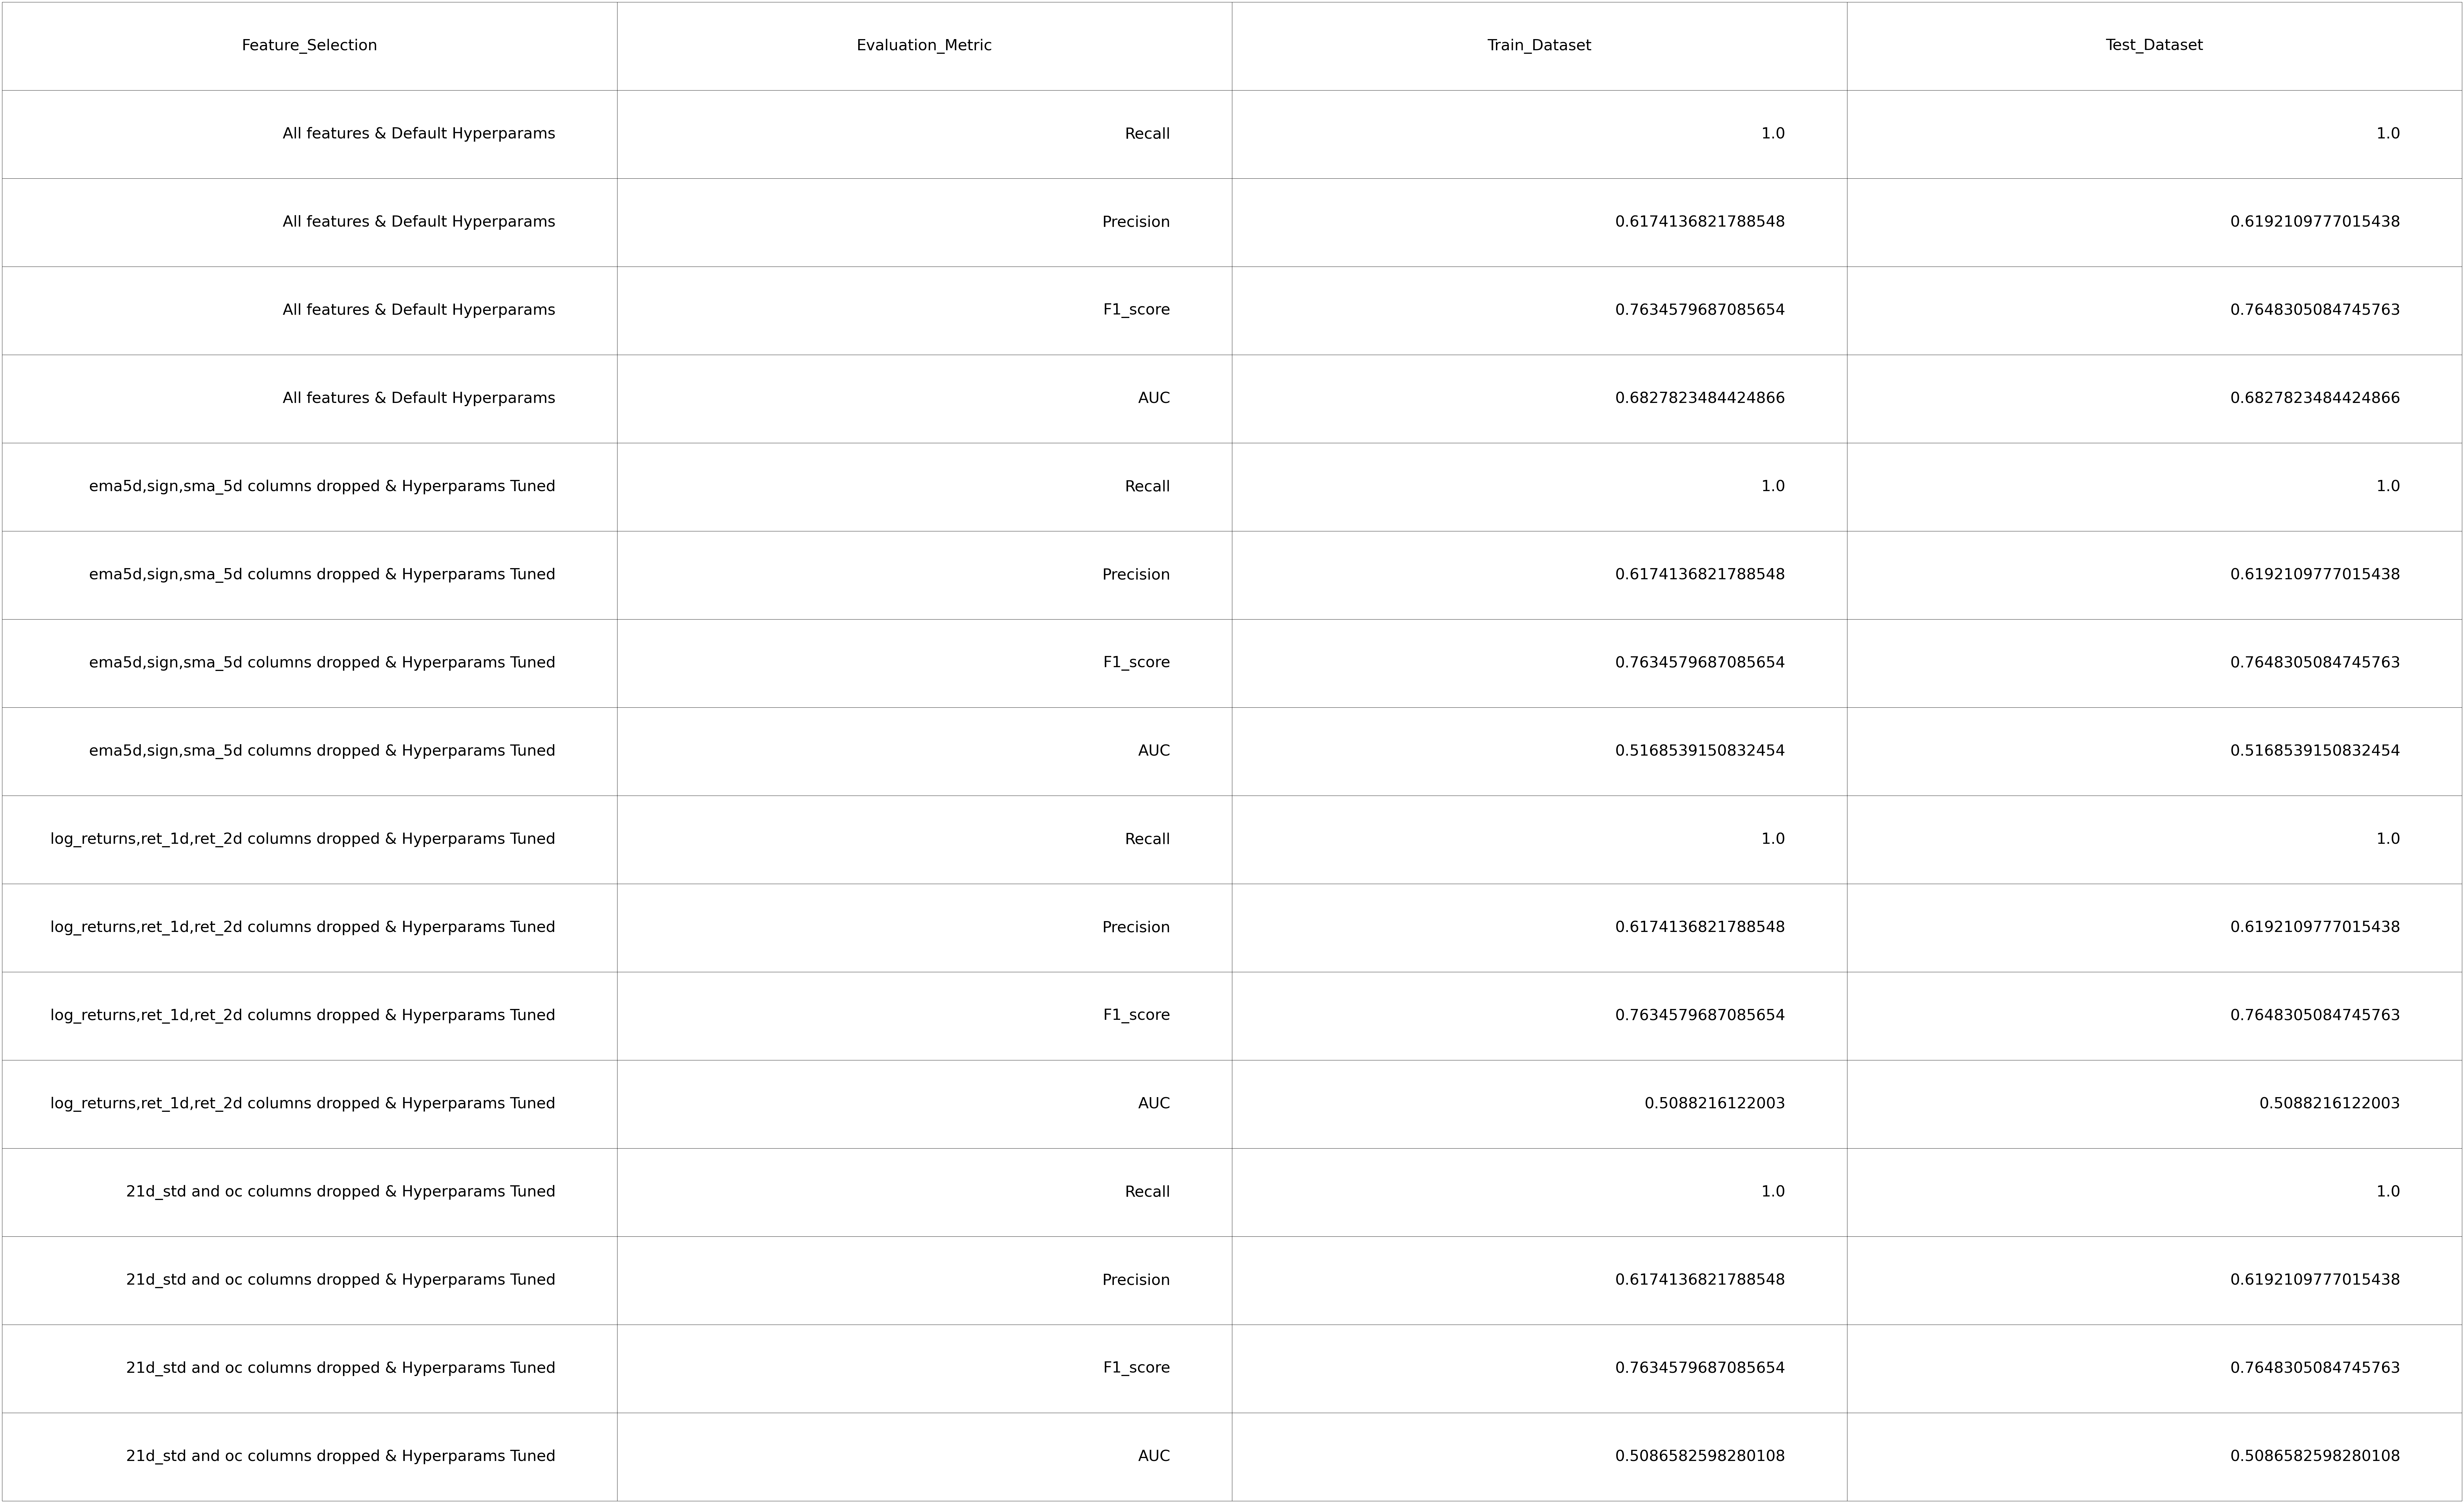

In [80]:
plt.figure(figsize=(50,50))
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


#create table
table = ax.table(cellText=results_summary.values, colLabels=results_summary.columns, loc='center')

#modify table
table.set_fontsize(250)
table.scale(25,25)
ax.axis('off')

#display table
plt.show()

### Conclusions

* We tested SVM with 4 different variations
<br>
<br>
 - Variation 1: Retain all Features and use Default Parameters for the SVM Model (without Hyperparameter tuning)
<br>
<br>
 - Variation 2: Dropped 3 columns (EVA_5d,Sign & SMA_5d columns and use Hyperparameter tuning on SVM Model
<br>
<br>
 - Variation 3: Dropped 3 columns (Log_returns,Ret_1d & Ret_2d columns and use Hyperparameter tuning on SVM Model
<br>
<br>
 - Variation 4: Dropped 2 columns (21d_std & OC columns and use Hyperparameter tuning on SVM Model
<br>
<br>
* Despite our efforts to increase the performance of all models by trying to normilize (scale) and balance a feature space, select features, we have not achieved impressive performance. 
<br>
<br>
* However, we could consider other machine learnig models such as logistic and ensemble models such as Random Forests(Bagging) and XGBoost(Bagging).